# Project l’impact des aliment sur l’environnement, de la production à la mise en vente

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scrap as scrap

In [4]:
""" 
decomenter pour lancer le scraping 
    - page_name = "agribalyse-31-detail-par-ingredient" ou
    - page_name = "agribalyse-31-detail-par-etape" ou
    - page_name = "agribalyse-31-synthese"
"""

# scrap.main(page_name="")  # scrap les données et les met dans des fichiers csv

' \ndecomenter pour lancer le scraping \n    - page_name = "agribalyse-31-detail-par-ingredient" ou\n    - page_name = "agribalyse-31-detail-par-etape" ou\n    - page_name = "agribalyse-31-synthese"\n'

In [5]:
df_ing = pd.read_csv("agribalyse-31-detail-par-ingredient.csv")
df_eta = pd.read_csv("agribalyse-31-detail-par-etape.csv")
df_syn = pd.read_csv("agribalyse-31-synthese.csv")

print(df_ing.shape)
print(df_eta.shape)
print(df_syn.shape)

(8840, 27)
(2500, 116)
(2500, 32)


## Pretraitement des données 

In [6]:
df_synt = df_syn.drop_duplicates(subset=["Code CIQUAL"], keep="first")
df_etape = df_eta.drop_duplicates(subset=["Code CIQUAL"], keep="first")

In [7]:
# remplissage des valeurs nulles
float_columns = df_synt.select_dtypes(include="float64").columns
float_columns_eta = df_eta.select_dtypes(include="float64").columns

# Traversée la data frame, remplissez les valeurs nulles comme moye
for column in float_columns:
    mean_value = df_synt[column].mean()
    df_synt[column].fillna(mean_value, inplace=True)

for column in float_columns_eta:
    mean_value = df_eta[column].mean()
    df_eta[column].fillna(mean_value, inplace=True)

# supprimer les lignes avec des strings vide
df_synt = df_synt.dropna()
df_eta = df_eta.dropna()


# Définir un seuil de 1.96 écarts types (intervalle de confiance à 95 %)
# threshold = 1.96

# # Calculer la moyenne et l'écart type
# mean = np.mean(df_synt["DQR"])
# std = np.std(df_synt["DQR"])

# # Calculer les bornes de l'intervalle de confiance
# low_bound = mean - std * threshold

# Filtrer les lignes avec des valeurs dans l'intervalle de confiance
df_synt = df_synt[df_synt["DQR"] <= 4]

# # Définir un seuil de 3 écarts types
# threshold = 3
# float_columns = float_columns.drop("Score unique EF", errors="ignore")
# float_columns = float_columns.drop("DQR", errors="ignore")

# for column in float_columns:
#     mean = np.mean(df_synt[column])
#     std = np.std(df_synt[column])
#     low_bound = mean - std * threshold
#     upper_bound = mean + std * threshold

#     df_synt[column] = np.where(df_synt[column] < low_bound, low_bound, df_synt[column])
#     df_synt[column] = np.where(
#         df_synt[column] > upper_bound, upper_bound, df_synt[column]
#     )

C:\Users\Saliou\AppData\Local\Temp\ipykernel_27328\3161595147.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_synt[column].fillna(mean_value, inplace=True)


In [8]:
df_synt.columns

Index(['Code AGB', 'Code CIQUAL', 'Groupe d'aliment', 'Sous-groupe d'aliment',
       'Nom du Produit en Français', 'LCI Name', 'code saison', 'code avion',
       'Livraison', 'Matériau d'emballage', 'Préparation', 'DQR',
       'Score unique EF', 'Changement climatique',
       'Appauvrissement de la couche d'ozone', 'Rayonnements ionisants',
       'Formation photochimique d'ozone', 'Particules fines',
       'Effets toxicologiques sur la santé humaine   substances non-cancérogènes',
       'Effets toxicologiques sur la santé humaine   substances cancérogènes',
       'Acidification terrestre et eaux douces', 'Eutrophisation eaux douces',
       'Eutrophisation marine', 'Eutrophisation terrestre',
       'Écotoxicité pour écosystèmes aquatiques d'eau douce',
       'Utilisation du sol', 'Épuisement des ressources eau',
       'Épuisement des ressources énergétiques',
       'Épuisement des ressources minéraux', ' id', ' i', ' rand'],
      dtype='object')

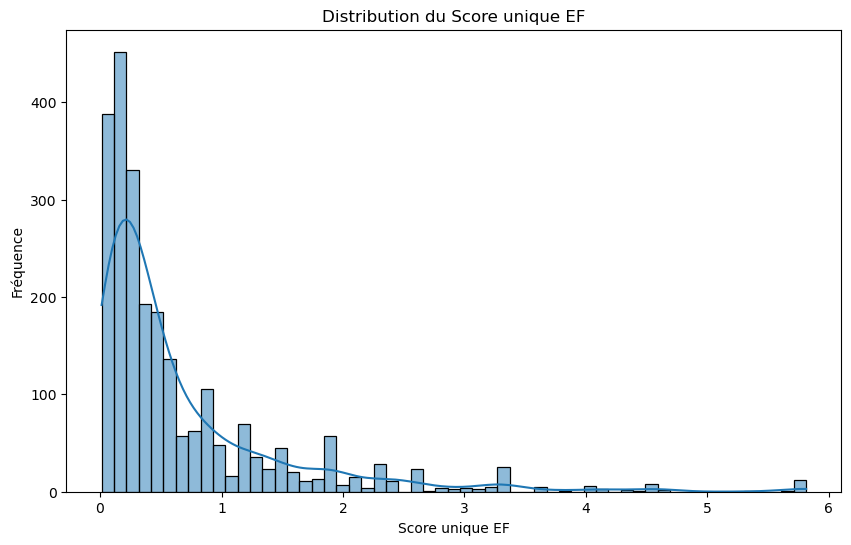

In [9]:
# Histogramme du 'Score unique EF'
plt.figure(figsize=(10, 6))
sns.histplot(df_synt["Score unique EF"], kde=True)
plt.title("Distribution du Score unique EF")
plt.xlabel("Score unique EF")
plt.ylabel("Fréquence")
plt.show()

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from warnings import filterwarnings


scaler = MinMaxScaler()
X = df_synt.iloc[:, 12:-3]
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=df_synt.columns[12:-3])

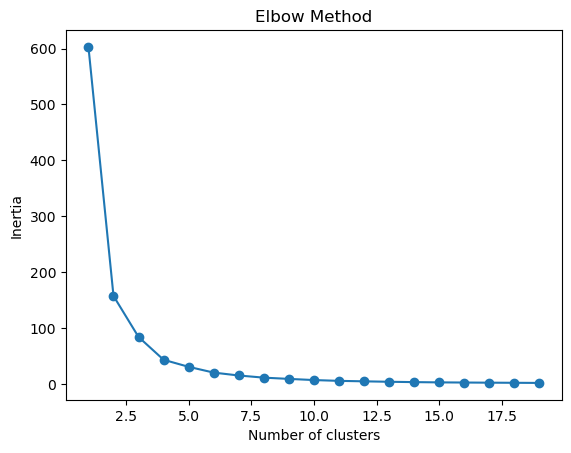

In [11]:
filterwarnings("ignore")
inertia = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X.values.reshape(-1, 1))
    inertia.append(kmeans.inertia_)
plt.figure()
plt.plot(range(1, 20), inertia, marker="o")
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

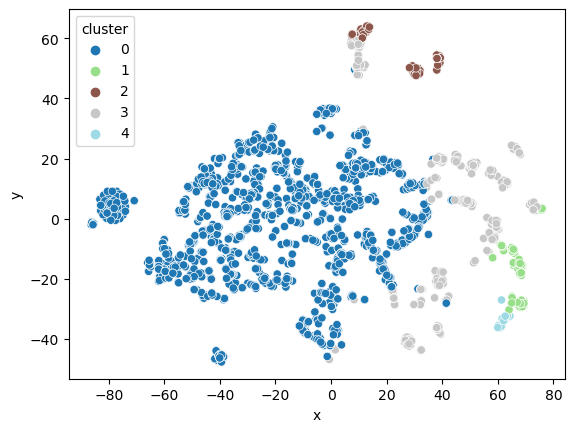

In [12]:
tab20 = sns.color_palette("tab20", as_cmap=True)

tsne = TSNE()
tsne_data = tsne.fit_transform(X)

km = KMeans(n_clusters=5)
pred = km.fit_predict(X)

# afficher avec des couleur et des legendes
df = pd.DataFrame(tsne_data, columns=["x", "y"])
df["cluster"] = pred
sns.scatterplot(data=df, x="x", y="y", hue="cluster", palette=tab20)
plt.show()

In [13]:
df_synt["cluster"] = pred  # Ajout des prédictions de cluster au DataFrame

# Créez un dictionnaire pour stocker les aliments par cluster
clusters = {}
for i in range(km.n_clusters):
    # Sélectionner les noms des aliments et les scores EF pour chaque cluster
    clusters[i] = (
        df_synt[df_synt["cluster"] == i][["Sous-groupe d'aliment", "Score unique EF"]]
        .drop_duplicates()
        .values.tolist()
    )

# Calculer la moyenne des scores EF pour chaque cluster
moyennes_clusters = {}
for cluster, aliments_scores in clusters.items():
    # Calculer la moyenne des scores EF pour le cluster actuel
    moyenne_ef = sum(score for _, score in aliments_scores) / len(aliments_scores)
    moyennes_clusters[cluster] = moyenne_ef

In [14]:
clusters

{0: [['herbes', 0.064652051],
  ['herbes', 0.1315805599999999],
  ['ingrédients divers', 0.21758125],
  ['ingrédients divers', 0.14641667],
  ['herbes', 0.39723177],
  ['ingrédients divers', 0.22008005],
  ['herbes', 0.090675554],
  ['herbes', 0.1089281399999999],
  ['épices', 0.12981155],
  ['sauces', 0.21492564],
  ['herbes', 0.11462818],
  ['sels', 0.078543661],
  ['ingrédients divers', 0.24452345],
  ['épices', 0.0766040009999999],
  ['sauces', 0.31411394],
  ['sauces', 0.29005398],
  ['herbes', 0.40053848],
  ['sauces', 0.16880909],
  ['sauces', 0.14632883],
  ['ingrédients divers', 0.52721804],
  ['ingrédients divers', 0.41928163],
  ['ingrédients divers', 0.4289488099999999],
  ['sauces', 0.45353566],
  ['herbes', 0.25076927],
  ['ingrédients divers', 0.2630390999999999],
  ['condiments', 0.30998072],
  ['condiments', 0.29599382],
  ['épices', 0.14350739],
  ['condiments', 0.13091212],
  ['épices', 0.4556189],
  ['herbes', 0.1854396],
  ['herbes', 0.7169294900000001],
  ['aides 

In [15]:
moyennes_clusters

{0: 0.28063401196690535,
 1: 2.703827284090909,
 2: 1.990822867647059,
 3: 1.192570203225807,
 4: 4.7627223249999995}

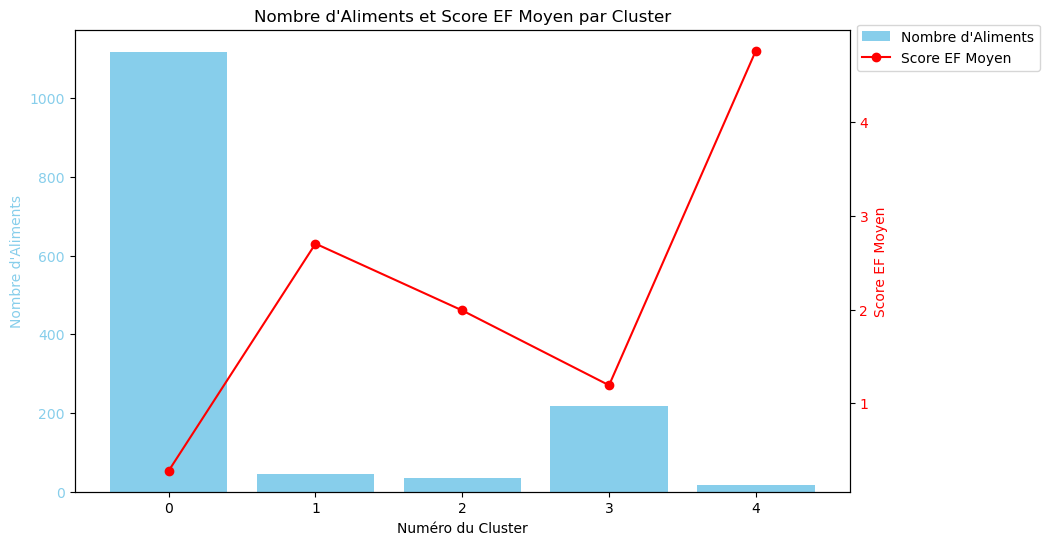

In [16]:
cluster_labels = list(clusters.keys())
aliments_par_cluster = [len(clusters[cluster]) for cluster in cluster_labels]
scores_moyens_ef = [moyennes_clusters[cluster] for cluster in cluster_labels]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Créer le diagramme à barres pour le nombre d'aliments par cluster
ax1.bar(
    cluster_labels, aliments_par_cluster, color="skyblue", label="Nombre d'Aliments"
)
ax1.set_xlabel("Numéro du Cluster")
ax1.set_ylabel("Nombre d'Aliments", color="skyblue")
ax1.tick_params(axis="y", labelcolor="skyblue")
ax1.set_title("Nombre d'Aliments et Score EF Moyen par Cluster")

# Créer un second axe pour les scores EF moyens
ax2 = ax1.twinx()
ax2.plot(
    cluster_labels, scores_moyens_ef, color="red", label="Score EF Moyen", marker="o"
)
ax2.set_ylabel("Score EF Moyen", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Ajouter une légende
fig.legend(loc="upper left", bbox_to_anchor=(0.9, 0.9))

plt.xticks(cluster_labels)
plt.show()

In [17]:
# Find the key with the maximum value
key_max_value = max(moyennes_clusters, key=moyennes_clusters.get)

print(key_max_value)  # Outputs: 'b'

4


In [18]:
clusters_uniques = {}
for cluster in clusters.keys():
    # Sélectionner les aliments uniques pour chaque cluster
    clusters_uniques[cluster] = df_synt[df_synt["cluster"] == cluster][
        "Sous-groupe d'aliment"
    ].unique()

# Afficher les aliments uniques pour chaque cluster
clusters_uniques[key_max_value]

array(['boissons sans alcool', 'viandes cuites', 'viandes crues',
       'autres produits à base de viande', 'charcuteries'], dtype=object)

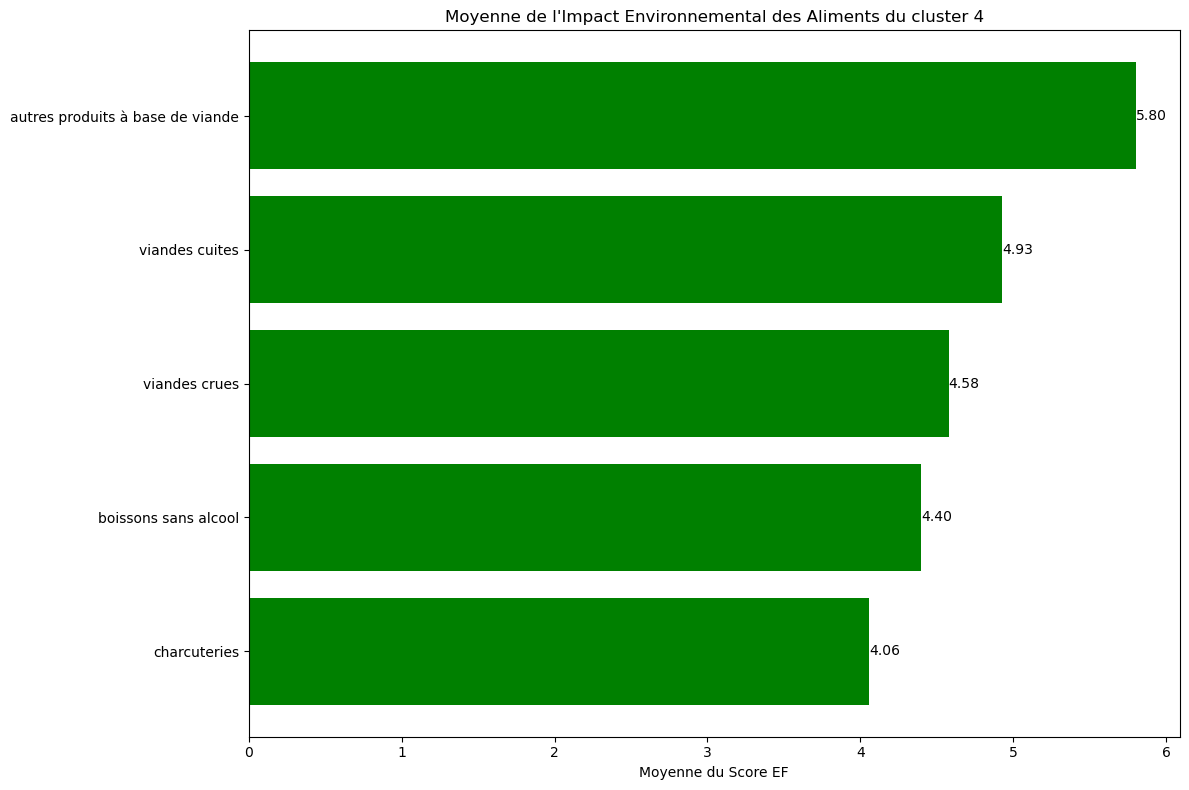

In [19]:
from collections import defaultdict

aliments_scores_cluster_5 = clusters[key_max_value]

# Créer un dictionnaire pour cumuler les scores EF et compter les occurrences des aliments de même nom
cumul_scores_ef = defaultdict(
    lambda: [0, 0]
)  # Le premier élément est la somme des scores, le second est le compteur
for aliment, score_ef in aliments_scores_cluster_5:
    cumul_scores_ef[aliment][0] += score_ef
    cumul_scores_ef[aliment][1] += 1

# Calculer la moyenne des scores EF pour les aliments de même nom
moyennes_scores_ef = {
    aliment: total_score / count
    for aliment, (total_score, count) in cumul_scores_ef.items()
}

# Convertir le dictionnaire des moyennes en une liste triée pour la visualisation
aliments_moyennes = sorted(
    moyennes_scores_ef.items(), key=lambda item: item[1], reverse=True
)

# Extraire les noms des aliments et les moyennes des scores EF
noms_aliments_moyennes = [aliment for aliment, _ in aliments_moyennes]
moyennes_ef = [moyenne for _, moyenne in aliments_moyennes]

plt.figure(figsize=(12, 8))
bars = plt.barh(noms_aliments_moyennes, moyennes_ef, color="green")
plt.xlabel("Moyenne du Score EF")
plt.title(
    f"Moyenne de l'Impact Environnemental des Aliments du cluster {key_max_value}"
)
plt.gca().invert_yaxis()  # Inverser l'axe y pour afficher le score le plus élevé en haut

# Ajouter des annotations sur chaque barre
for bar in bars:
    plt.text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():.2f}",
        va="center",
        ha="left",
        color="black",
    )

plt.tight_layout()
plt.show()

In [20]:
df_cluster_5 = df_synt[df_synt["cluster"] == key_max_value]
df_etape_5 = df_etape.iloc[:, 6:-3]

# Save "Code CIQUAL" column in a variable
code_ciqual = df_etape["Code CIQUAL"]

# Insert "Code CIQUAL" column at position 0
df_etape_5.insert(0, "Code CIQUAL", code_ciqual)

# Perform the join
df_jointure = pd.merge(df_cluster_5, df_etape_5, on="Code CIQUAL")


print(df_cluster_5.shape)


print(df_jointure.shape)

(32, 33)
(32, 140)


In [21]:
df_jointure.head()

,Code AGB,Code CIQUAL,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,LCI Name,code saison,code avion,Livraison,Matériau d'emballage,...,Épuisement des ressources minéraux - Transformation,Épuisement des ressources minéraux - Emballage,Épuisement des ressources minéraux - Transport,Épuisement des ressources minéraux - Supermarché et distribution,Épuisement des ressources minéraux - Consommation,DQR - Global,DQR - P,DQR - TiR,DQR - GR,DQR - TeR
0,18069,18069,boissons,boissons sans alcool,"Café, décaféiné, poudre soluble","Decaffeinated coffee, powder, instant, non reh...",2,False,Ambiant (long),Carton,...,1.492758e-05,4.659462e-07,0.000001,4.396778e-07,0.000000e+00,3.49,3.72,3.41,2.29,4.54
1,18005,18005,boissons,boissons sans alcool,"Café, poudre soluble","Coffee, powder, instant, non rehydrated",2,False,Ambiant (long),Carton,...,1.007542e-05,4.659462e-07,0.000001,4.396778e-07,0.000000e+00,3.49,3.72,3.41,2.29,4.54
2,21508,21508,"viandes, œufs, poissons",viandes cuites,"Agneau, collier, braisé ou bouilli","Lamb, neck, braised or boiled",2,False,Glacé,PS,...,3.148007e-07,5.337783e-08,0.000001,1.443461e-06,3.826202e-06,2.65,3.66,1.28,2.04,3.60
3,21514,21514,"viandes, œufs, poissons",viandes crues,"Agneau, collier, cru","Lamb, neck, raw",2,False,Glacé,PS,...,2.491977e-07,4.225414e-08,0.000001,1.142650e-06,3.454751e-07,2.63,3.69,1.21,2.01,3.62
4,21516,21516,"viandes, œufs, poissons",viandes crues,"Agneau, côte filet, crue","Lamb, chop fillet, raw",2,False,Glacé,PS,...,2.491977e-07,4.225414e-08,0.000001,1.142650e-06,3.454751e-07,2.63,3.69,1.21,2.01,3.62


In [22]:
df_jointure.columns[12:29]

Index(['Score unique EF', 'Changement climatique',
       'Appauvrissement de la couche d'ozone', 'Rayonnements ionisants',
       'Formation photochimique d'ozone', 'Particules fines',
       'Effets toxicologiques sur la santé humaine   substances non-cancérogènes',
       'Effets toxicologiques sur la santé humaine   substances cancérogènes',
       'Acidification terrestre et eaux douces', 'Eutrophisation eaux douces',
       'Eutrophisation marine', 'Eutrophisation terrestre',
       'Écotoxicité pour écosystèmes aquatiques d'eau douce',
       'Utilisation du sol', 'Épuisement des ressources eau',
       'Épuisement des ressources énergétiques',
       'Épuisement des ressources minéraux'],
      dtype='object')

In [23]:
from statsmodels.stats.multicomp import MultiComparison

scaler = MinMaxScaler()
df_join_norm = df_jointure.copy()
df_join_norm = scaler.fit_transform(df_join_norm.iloc[:, 12:29])
df_join_norm = pd.DataFrame(df_join_norm, columns=df_jointure.columns[12:29])
df_join_norm["Sous-groupe d'aliment"] = df_jointure["Sous-groupe d'aliment"]

mc = MultiComparison(
    df_join_norm["Changement climatique"], df_join_norm["Sous-groupe d'aliment"]
)

result = mc.tukeyhsd(alpha=0.05)

print(result.summary())

                    Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
             group1                     group2        meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------------------
autres produits à base de viande boissons sans alcool  -0.9557  0.001 -1.5765 -0.335   True
autres produits à base de viande         charcuteries  -0.5063  0.151 -1.1271 0.1144  False
autres produits à base de viande        viandes crues  -0.4356 0.1556 -0.9731  0.102  False
autres produits à base de viande       viandes cuites  -0.1793 0.8499 -0.6993 0.3407  False
            boissons sans alcool         charcuteries   0.4494 0.1007 -0.0575 0.9562  False
            boissons sans alcool        viandes crues   0.5202 0.0063  0.1195 0.9209   True
            boissons sans alcool       viandes cuites   0.7765    0.0  0.3997 1.1532   True
                    charcuteries        viandes crues   0.0708  0.985 -0.3299 0.

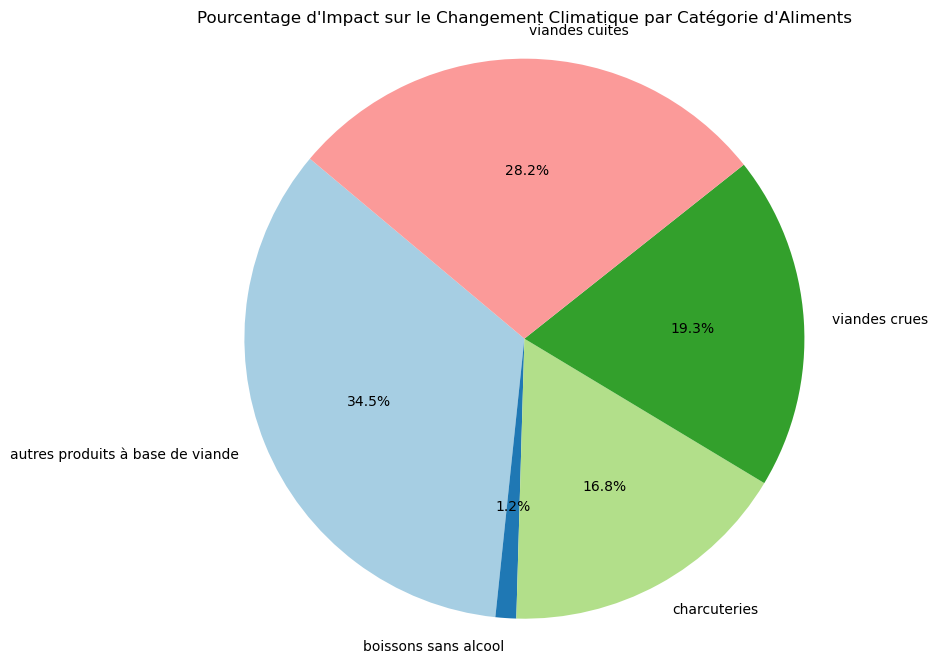

In [24]:
# Calculer la moyenne du score EF pour chaque catégorie
moyennes_par_categorie = df_join_norm.groupby("Sous-groupe d'aliment")[
    "Changement climatique"
].mean()

# Préparer les données pour le diagramme en camembert
labels = moyennes_par_categorie.index
sizes = moyennes_par_categorie.values
colors = plt.cm.Paired(range(len(labels)))  # Générer des couleurs pour chaque catégorie

# Créer le diagramme en camembert
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=140)
plt.axis("equal")  # Assurer que le camembert est un cercle
plt.title("Pourcentage d'Impact sur le Changement Climatique par Catégorie d'Aliments")
plt.show()

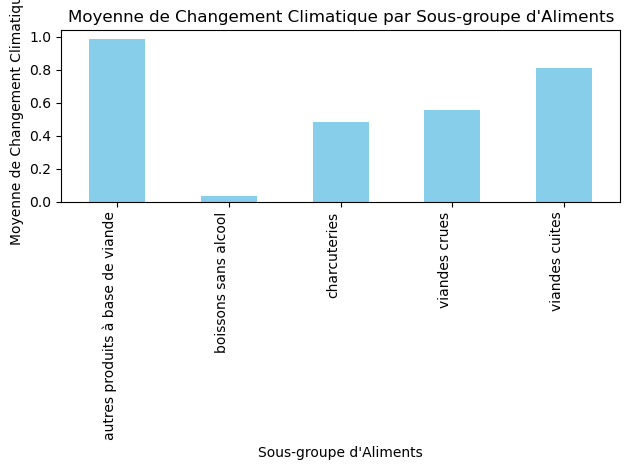

In [25]:
# Création du diagramme en barresplt.figure(figsize=(10, 6))
moyennes_par_categorie.plot(kind="bar", color="skyblue")

# Ajouter des titres et des étiquettes
plt.title("Moyenne de Changement Climatique par Sous-groupe d'Aliments")
plt.xlabel("Sous-groupe d'Aliments")
plt.ylabel("Moyenne de Changement Climatique")
plt.xticks(rotation=90, ha="right")

plt.tight_layout()
plt.show()

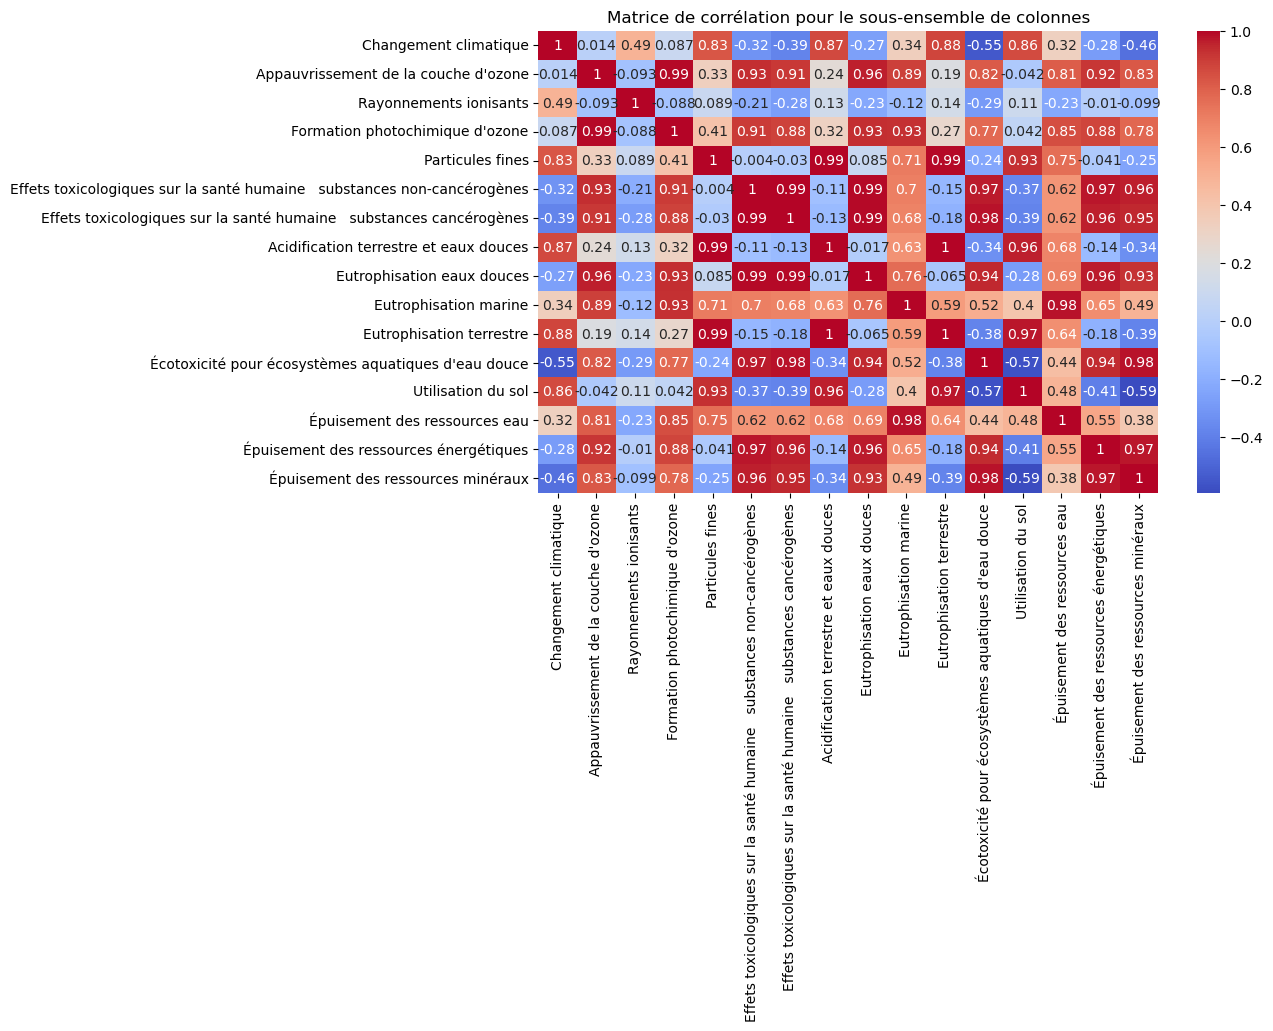

In [26]:
df_subset = df_join_norm.iloc[:, 1:-1]
# Matrice de corrélation pour le sous-ensemble
correlation_matrix_subset = df_subset.corr()

# Heatmap des corrélations pour le sous-ensemble
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_subset, annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation pour le sous-ensemble de colonnes")
plt.show()

In [27]:
from sklearn.decomposition import PCA

# Supposons que df_join_norm est votre DataFrame et contient les indicateurs d'impact environnemental
# Sélectionner les colonnes d'impact environnemental pour l'ACP
colonnes_impact = df_join_norm.columns[1:-1]

# Préparer les données pour l'ACP
X = df_join_norm[colonnes_impact]

# Initialiser l'ACP
pca = PCA()  # Utiliser tous les composantes pour l'exemple
X_r = pca.fit_transform(X)

summary_table = pd.DataFrame(
    columns=[
        "Dimension",
        "Explained Variance",
        "Explained Variance Ratio",
        "Cumulative Explained Variance Ratio",
    ]
)

# Créer une liste pour stocker les lignes du tableau récapitulatif
rows = []

# Calculer les proportions cumulatives de variance expliquée
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Remplir la liste avec les informations sur chaque dimension
for i in range(len(pca.explained_variance_)):
    rows.append(
        {
            "Dimension": i + 1,
            "Explained Variance": pca.explained_variance_[i],
            "Explained Variance Ratio": pca.explained_variance_ratio_[i],
            "Cumulative Explained Variance Ratio": cumulative_variance_ratio[i],
        }
    )

# Créer le DataFrame récapitulatif en concaténant les lignes
summary_table = pd.concat([pd.DataFrame([row]) for row in rows], ignore_index=True)

summary_table

,Dimension,Explained Variance,Explained Variance Ratio,Cumulative Explained Variance Ratio
0,1,6.778787e-01,5.129386e-01,0.512939
1,2,5.156703e-01,3.901984e-01,0.903137
2,3,1.199902e-01,9.079441e-02,0.993931
3,4,7.213914e-03,5.458639e-03,0.999390
4,5,7.539446e-04,5.704962e-04,0.999961
5,6,3.447021e-05,2.608299e-05,0.999987
6,7,1.594424e-05,1.206472e-05,0.999999
7,8,9.772846e-07,7.394936e-07,0.999999
8,9,6.475944e-07,4.900230e-07,1.000000
9,10,6.974055e-08,5.277141e-08,1.000000


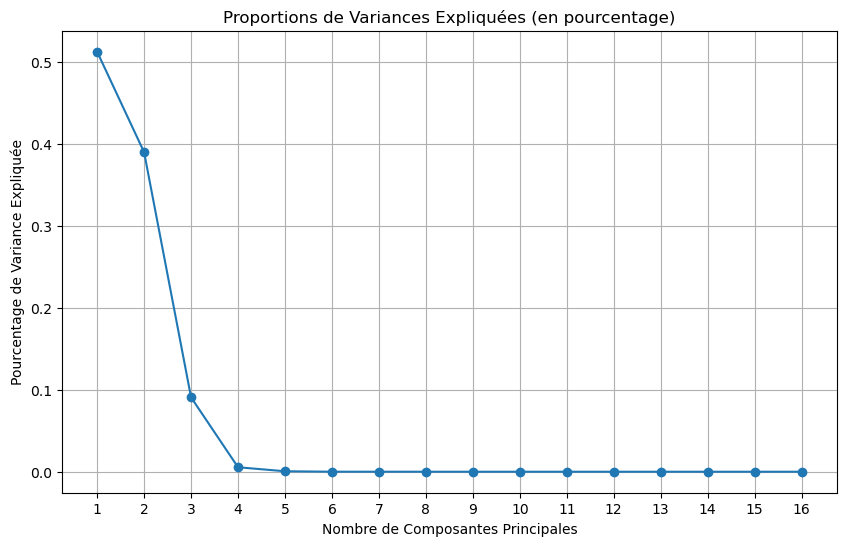

In [28]:
# Calculer les proportions cumulatives de variance expliquée
cumulative_variance_ratio_percent = pca.explained_variance_ratio_ * 100

# Tracer le graphique des proportions de variance expliquée en pourcentage
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1),
    pca.explained_variance_ratio_,
    marker="o",
    linestyle="-",
)
plt.title("Proportions de Variances Expliquées (en pourcentage)")
plt.xlabel("Nombre de Composantes Principales")
plt.ylabel("Pourcentage de Variance Expliquée")
plt.xticks(range(1, len(cumulative_variance_ratio_percent) + 1))
plt.grid(True)
plt.show()

In [29]:
n = X.shape[0]  # nb of individuals
p = X.shape[1]  # nb of variables
print(n, "  ", p)
eigval = (n - 1) / n * pca.explained_variance_  # eigen values
sqrt_eigval = np.sqrt(eigval)
corvar = np.zeros((p, p))  # empty matrix for coordinates
for k in range(p):
    corvar[:, k] = pca.components_[k, :] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({"id": X.columns, "COR_1": corvar[:, 0], "COR_2": corvar[:, 1]})
coordvar

32    16


,id,COR_1,COR_2
0,Changement climatique,0.190601,-0.153509
1,Appauvrissement de la couche d'ozone,0.130778,0.180842
2,Rayonnements ionisants,0.013841,-0.101466
3,Formation photochimique d'ozone,0.163667,0.189884
4,Particules fines,0.382460,-0.108377
5,Effets toxicologiques sur la santé humaine s...,0.060894,0.215212
6,Effets toxicologiques sur la santé humaine s...,0.056479,0.224695
7,Acidification terrestre et eaux douces,0.323776,-0.129087
8,Eutrophisation eaux douces,0.077123,0.202696
9,Eutrophisation marine,0.292118,0.162415


In [30]:
moyennes_par_categorie

Sous-groupe d'aliment
autres produits à base de viande    0.990059
boissons sans alcool                0.034335
charcuteries                        0.483717
viandes crues                       0.554506
viandes cuites                      0.810791
Name: Changement climatique, dtype: float64

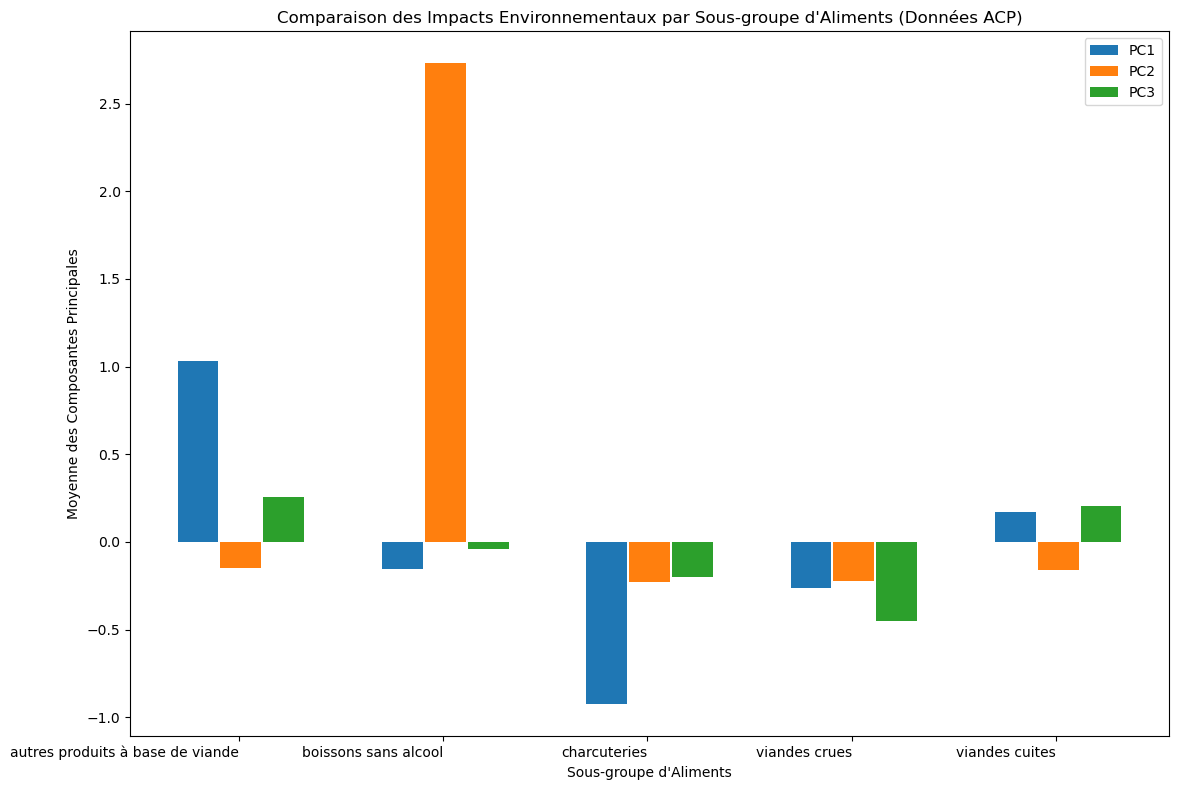

In [31]:
pca = PCA(n_components=3)  # Utiliser tous les composantes pour l'exemple
X_r = pca.fit_transform(X)


# Supposons que 'X_r' est le résultat de l'ACP et 'df_join_norm' contient les sous-groupes d'aliments
# Ajouter les sous-groupes d'aliments comme une nouvelle colonne dans les données réduites
X_r_df = pd.DataFrame(X_r, columns=["PC1", "PC2", "PC3"])
X_r_df["Sous-groupe d'aliment"] = df_join_norm["Sous-groupe d'aliment"].values

# Calculer les moyennes pour chaque sous-groupe
moyennes_par_categorie = X_r_df.groupby("Sous-groupe d'aliment").mean()

# Créer le graphique à barres groupées
fig, ax = plt.subplots(figsize=(12, 8))

# L'index pour les sous-groupes d'aliments
index = np.arange(len(moyennes_par_categorie))
bar_width = 0.2  # Largeur des barres
space_between_groups = 0.01  # Espace entre les groupes

# Créer une barre pour chaque composante principale
for i, pc in enumerate(["PC1", "PC2", "PC3"]):
    plt.bar(
        index + i * (bar_width + space_between_groups),
        moyennes_par_categorie[pc],
        bar_width,
        label=pc,
    )

ax.set_xlabel("Sous-groupe d'Aliments")
ax.set_ylabel("Moyenne des Composantes Principales")
ax.set_title(
    "Comparaison des Impacts Environnementaux par Sous-groupe d'Aliments (Données ACP)"
)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(moyennes_par_categorie.index)
ax.legend()

plt.xticks(rotation=0, ha="right")
plt.tight_layout()
plt.show()

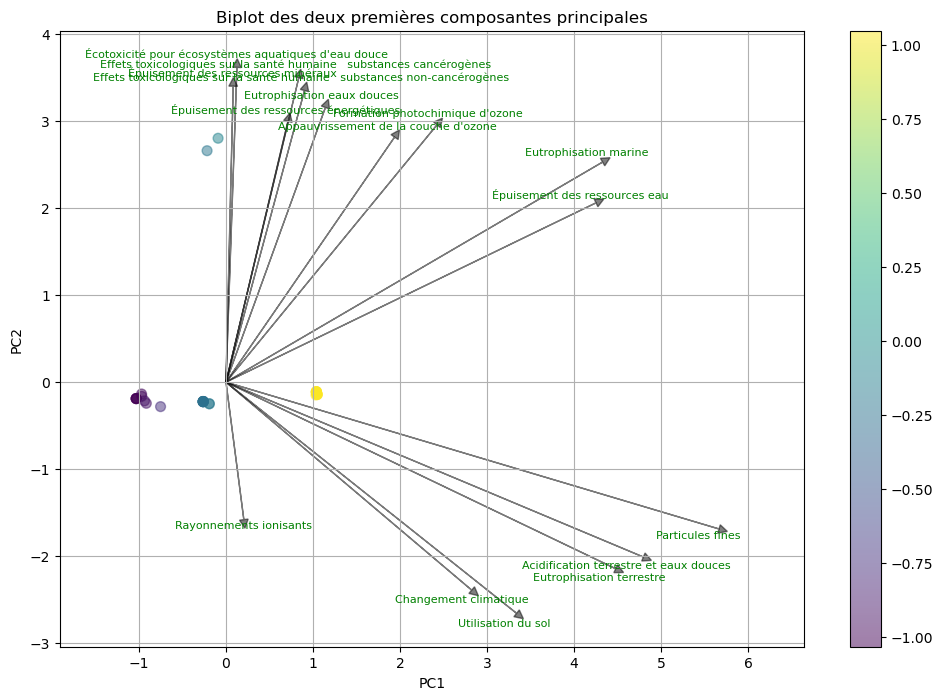

In [32]:
# Définir la taille du graphique
plt.figure(figsize=(12, 8))

# Utiliser les scores de la première composante principale comme couleurs
colors = X_r_df["PC1"]

# Tracer les points pour les deux composantes principales
plt.scatter(
    X_r_df.values[:, 0], X_r_df.values[:, 1], s=50, c=colors, cmap="viridis", alpha=0.5
)

# Ajouter des flèches pour les composantes principales et les annoter
for i in range(pca.components_.shape[1]):
    plt.arrow(
        0,
        0,
        pca.components_[0, i] * 12,
        pca.components_[1, i] * 11,
        alpha=0.5,
        head_width=0.1,
        head_length=0.1,
        fc="black",
        ec="black",
    )
    plt.text(
        pca.components_[0, i] * 10 * 1.15,
        pca.components_[1, i] * 10 * 1.15,
        X.columns[i],
        color="green",
        ha="center",
        va="center",
        fontsize=8,
    )

# Ajouter des titres et des étiquettes
plt.title("Biplot des deux premières composantes principales")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()  # Ajouter une barre de couleur pour indiquer l'échelle

# Afficher le graphique
plt.grid(True)
plt.axis("equal")
plt.show()

In [33]:
# Créer un DataFrame pour les vecteurs propres
loadings = pd.DataFrame(
    pca.components_.T, columns=["PC1", "PC2", "PC3"], index=X.columns
)
loadings

,PC1,PC2,PC3
Changement climatique,0.235204,-0.217191,0.251940
Appauvrissement de la couche d'ozone,0.161381,0.255863,0.095500
Rayonnements ionisants,0.017080,-0.143559,0.909211
Formation photochimique d'ozone,0.201967,0.268656,0.096718
Particules fines,0.471959,-0.153337,-0.045224
Effets toxicologiques sur la santé humaine substances non-cancérogènes,0.075143,0.304490,0.057854
Effets toxicologiques sur la santé humaine substances cancérogènes,0.069695,0.317909,0.004628
Acidification terrestre et eaux douces,0.399542,-0.182638,-0.027782
Eutrophisation eaux douces,0.095170,0.286782,0.030389
Eutrophisation marine,0.360476,0.229791,-0.010705


In [34]:
# Grouper les données par 'Sous-groupe d'aliment' et calculer la moyenne pour les indicateurs sélectionnés
moyennes_par_categorie = df_join_norm.groupby("Sous-groupe d'aliment").mean()

In [35]:
def plot_grouped_bar_chart(ax, data, columns, group, ymin, ymax):
    # Nombre de groupes d'aliments
    n_groups = len(data.index)

    # L'index pour les groupes d'aliments
    index = np.arange(n_groups)
    bar_width = 0.01  # Largeur des barres
    space_between_groups = 0.01  # Espace entre les groupes

    # Créer une barre pour chaque indicateur d'impact sélectionné
    for i, impact in enumerate(columns):
        ax.bar(
            index + i * (bar_width + space_between_groups),
            data[impact],
            bar_width,
            label=impact,
        )

    # Ajouter des légendes et des titres
    ax.set_ylabel("Scores EF Moyens")
    ax.set_title(f"Comparaison des Impacts Environnementaux pour {group}")
    ax.set_xticklabels(data.index)

    ax.set_xticklabels(data.index, rotation=0, ha="center")

    ax.set_ylim([ymin, ymax])


# Sélectionner les colonnes d'intérêt pour la comparaison
colonnes_impact_selectionnees = X.columns

groups = df_join_norm["Sous-groupe d'aliment"].unique()
plt.show()

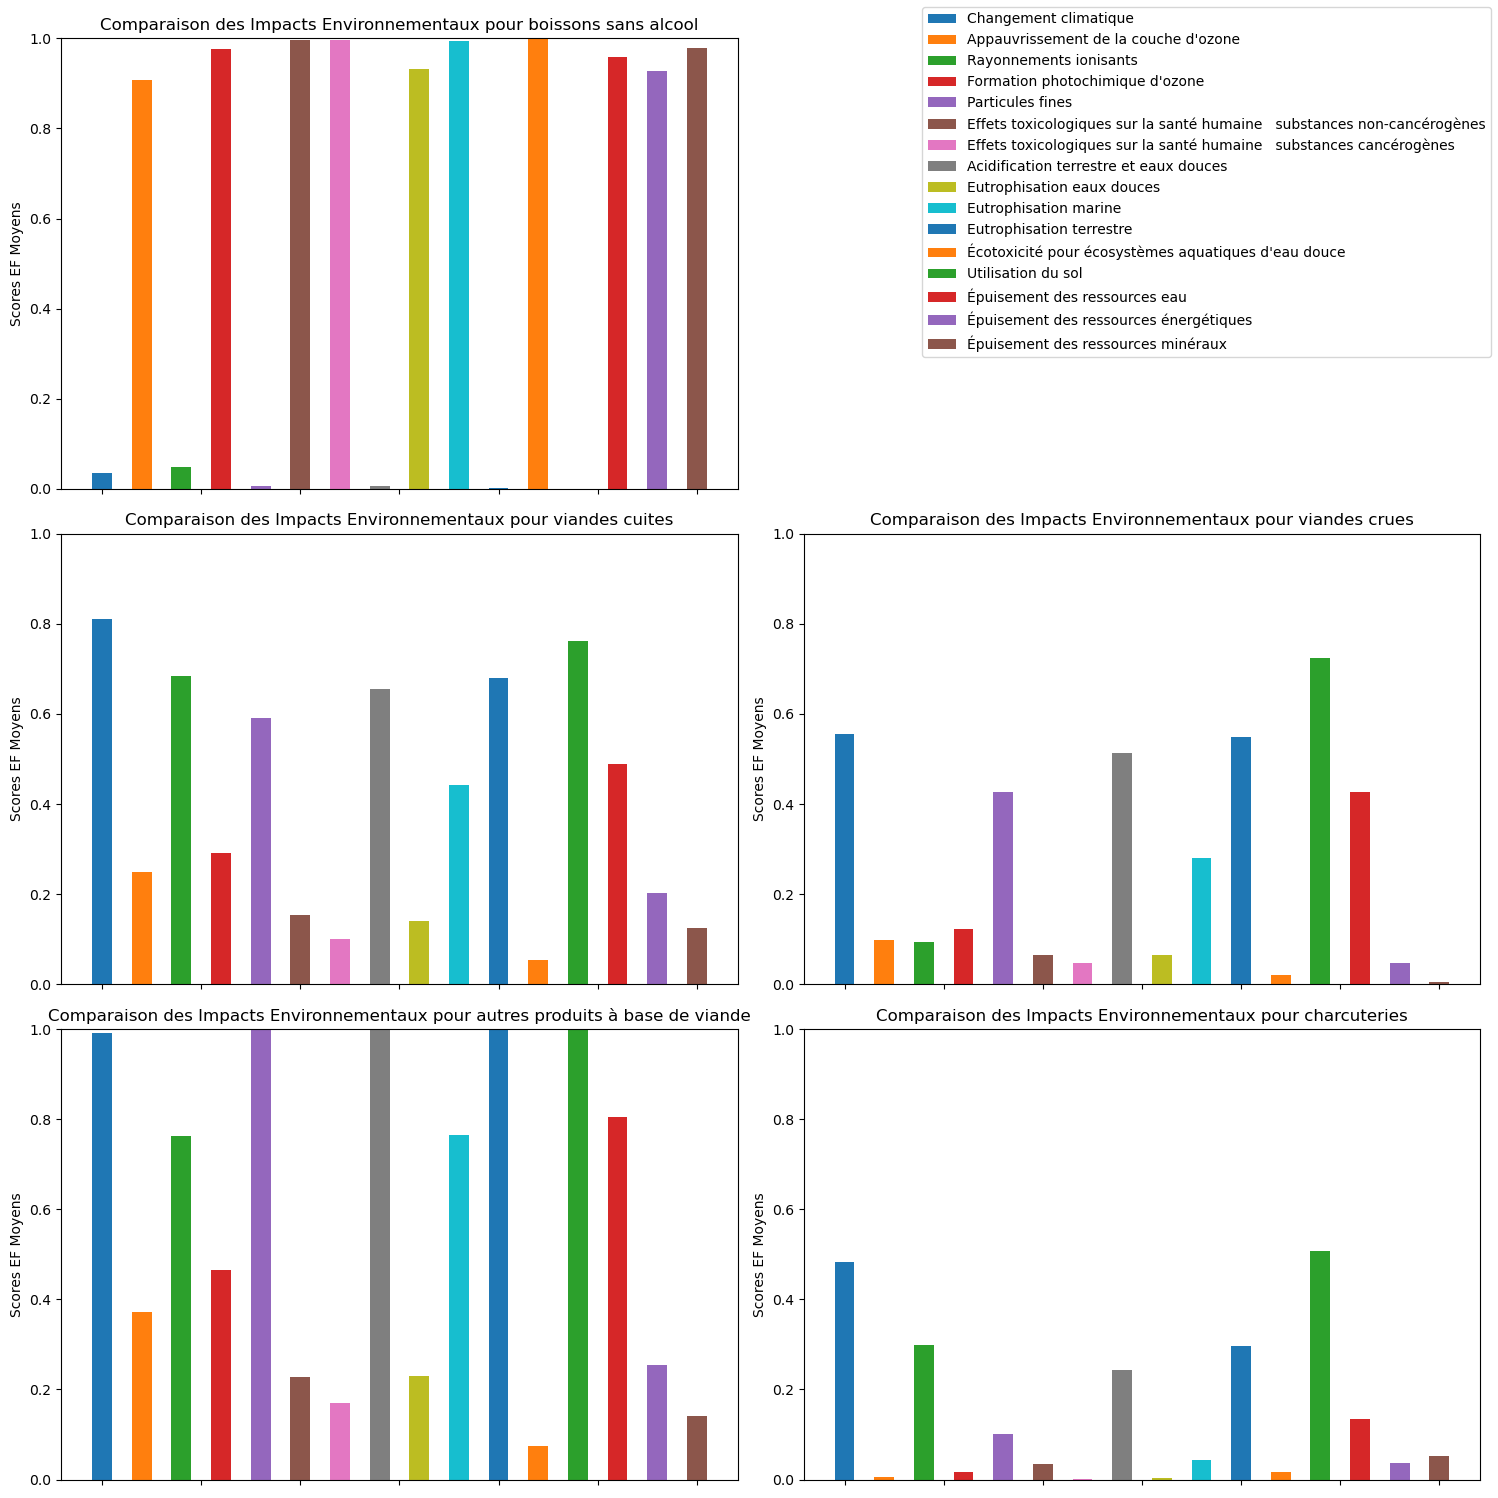

In [36]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a grid of subplots
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1])

# Create the first plot on the first row
ax1 = plt.subplot(gs[0, 0])
group = groups[0]
data_subset = moyennes_par_categorie.loc[[group]]
plot_grouped_bar_chart(ax1, data_subset, colonnes_impact_selectionnees, group, 0, 1)

# Create the second and third plots on the second row
for i in range(1, 3):
    ax = plt.subplot(gs[1, i - 1])
    group = groups[i]
    data_subset = moyennes_par_categorie.loc[[group]]
    plot_grouped_bar_chart(ax, data_subset, colonnes_impact_selectionnees, group, 0, 1)

# Create the fourth and fifth plots on the third row
for i in range(3, 5):
    ax = plt.subplot(gs[2, i - 3])
    group = groups[i]
    data_subset = moyennes_par_categorie.loc[[group]]
    plot_grouped_bar_chart(ax, data_subset, colonnes_impact_selectionnees, group, 0, 1)

# Display the legend outside of the plot area and only once for all subplots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.tight_layout()
plt.show()

In [37]:
# Supposons que 'moyennes_par_categorie' est votre DataFrame contenant les moyennes des impacts pour chaque sous-groupe d'aliments
seuil = 0.75

# Créer un dictionnaire pour stocker les impacts principaux pour chaque sous-groupe d'aliments
impacts_principaux = {}

# Parcourir chaque sous-groupe d'aliments
for sous_groupe, impacts in moyennes_par_categorie.iterrows():
    # Appliquer le seuil et récupérer les noms des impacts principaux
    impacts_principaux[sous_groupe] = list(
        impacts[impacts >= seuil * impacts.max()].index
    )

# Convertir le dictionnaire en DataFrame pour un affichage sous forme de tableau
df_impacts_principaux = pd.DataFrame(
    impacts_principaux.items(),
    columns=["Sous-groupe d'aliments", "Impacts Principaux"],
)

# Afficher le DataFrame
df_impacts_principaux

,Sous-groupe d'aliments,Impacts Principaux
0,autres produits à base de viande,"[Score unique EF, Changement climatique, Rayon..."
1,boissons sans alcool,"[Appauvrissement de la couche d'ozone, Formati..."
2,charcuteries,"[Changement climatique, Utilisation du sol]"
3,viandes crues,"[Changement climatique, Eutrophisation terrest..."
4,viandes cuites,"[Changement climatique, Rayonnements ionisants..."


```markdown
### Changement climatique

In [38]:
df_jointure.groupby("Sous-groupe d'aliment").count()

,Code AGB,Code CIQUAL,Groupe d'aliment,Nom du Produit en Français,LCI Name,code saison,code avion,Livraison,Matériau d'emballage,Préparation,...,Épuisement des ressources minéraux - Transformation,Épuisement des ressources minéraux - Emballage,Épuisement des ressources minéraux - Transport,Épuisement des ressources minéraux - Supermarché et distribution,Épuisement des ressources minéraux - Consommation,DQR - Global,DQR - P,DQR - TiR,DQR - GR,DQR - TeR
Sous-groupe d'aliment,,,,,,,,,,,,,,,,,,,,,
autres produits à base de viande,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
boissons sans alcool,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
charcuteries,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
viandes crues,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
viandes cuites,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19


In [39]:
df_jointure.columns[39:45]
# 51:57

Index(['Changement climatique - Agriculture',
       'Changement climatique - Transformation',
       'Changement climatique - Emballage',
       'Changement climatique - Transport',
       'Changement climatique - Supermarché et distribution',
       'Changement climatique - Consommation'],
      dtype='object')

In [40]:
df_viande_cuite = df_jointure[df_jointure["Sous-groupe d'aliment"] == "viandes cuites"]
cols = ["Code CIQUAL"]
cols += list(df_jointure.columns[39:45])
df_viande_cuite = df_viande_cuite[cols]
df_viande_cuite

,Code CIQUAL,Changement climatique - Agriculture,Changement climatique - Transformation,Changement climatique - Emballage,Changement climatique - Transport,Changement climatique - Supermarché et distribution,Changement climatique - Consommation
2,21508,49.872242,0.083945,0.434732,0.320083,0.058984,0.197933
5,21509,49.884419,0.085250,0.434770,0.320849,0.058984,0.223161
7,21512,49.884419,0.085250,0.434770,0.320849,0.058984,0.223161
9,21501,49.913757,0.085300,0.406857,0.320990,0.059019,0.221058
10,21507,39.897793,0.067156,0.347786,0.256067,0.047188,0.094321
11,21506,39.897793,0.067156,0.347786,0.256067,0.047188,0.094321
12,21519,49.872242,0.083945,0.434732,0.320083,0.058984,0.197933
14,21518,49.884419,0.085250,0.434770,0.320849,0.058984,0.223161
15,21503,49.872242,0.083945,0.434732,0.320083,0.058984,0.197933
17,21520,49.884419,0.085250,0.434770,0.320849,0.058984,0.223161


In [41]:
import scipy.stats as stats

f_value, p_value = stats.f_oneway(
    df_viande_cuite["Changement climatique - Transformation"],
    df_viande_cuite["Changement climatique - Emballage"],
    df_viande_cuite["Changement climatique - Transport"],
    df_viande_cuite["Changement climatique - Supermarché et distribution"],
    df_viande_cuite["Changement climatique - Consommation"],
)

# Afficher les résultats du test ANOVA
print(f"F-value: {f_value}, P-value: {p_value}")

# Si le P-value est inférieur à 0.05, cela indique des différences significatives
if p_value < 0.05:
    print("Des différences significatives existent entre les groupes.")
else:
    print("Aucune différence significative n'a été trouvée entre les groupes.")

F-value: 105.94158927380451, P-value: 3.448079690798821e-33
Des différences significatives existent entre les groupes.


In [42]:
# Calculer la somme ou la moyenne des impacts pour chaque étape
impact_transformation = df_viande_cuite["Changement climatique - Transformation"].mean()
impact_emballage = df_viande_cuite["Changement climatique - Emballage"].mean()
impact_transport = df_viande_cuite["Changement climatique - Transport"].mean()
impact_supermarche = df_viande_cuite[
    "Changement climatique - Supermarché et distribution"
].mean()
impact_consommation = df_viande_cuite["Changement climatique - Consommation"].mean()

# Créer un dictionnaire pour stocker les résultats
impacts = {
    "Transformation": impact_transformation,
    "Emballage": impact_emballage,
    "Transport": impact_transport,
    "Supermarché et distribution": impact_supermarche,
    "Consommation": impact_consommation,
}

# Trouver l'étape avec le plus grand impact
etape_plus_impact = max(impacts, key=impacts.get)

# Afficher l'étape avec le plus grand impact
print(
    f"L'étape ayant le plus grand impact sur le changement climatique est : {etape_plus_impact} avec une moyenne de {impacts[etape_plus_impact]}"
)
impacts

L'étape ayant le plus grand impact sur le changement climatique est : Emballage avec une moyenne de 0.40601376157894736


{'Transformation': 0.14147667431578947,
 'Emballage': 0.40601376157894736,
 'Transport': 0.302254647368421,
 'Supermarché et distribution': 0.05552497521052632,
 'Consommation': 0.186548414}

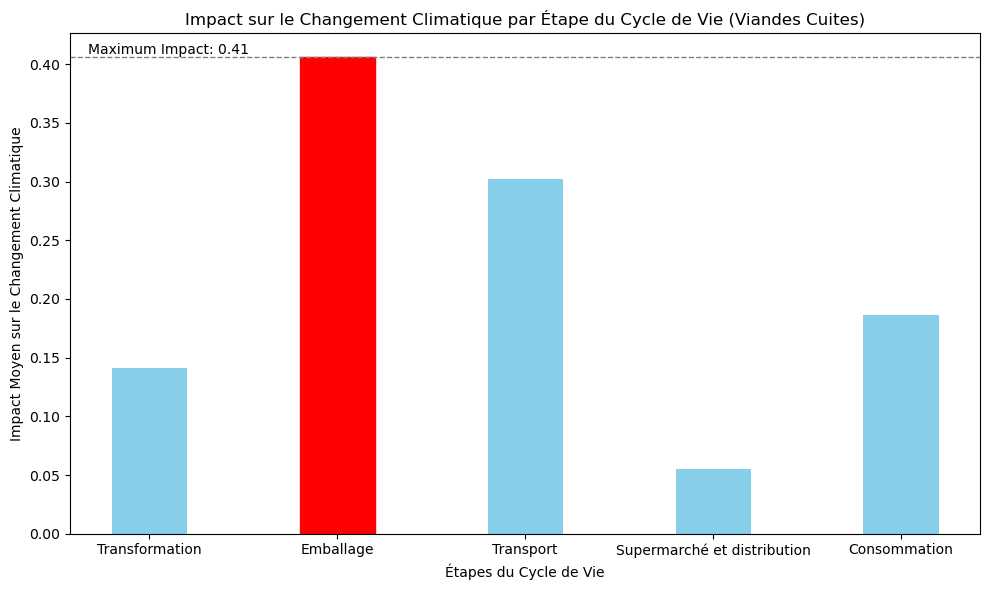

In [43]:
# Trouver l'étape avec le plus grand impact
etape_plus_impact = max(impacts, key=impacts.get)
max_value = impacts[etape_plus_impact]

# Créer le graphique à barres
plt.figure(figsize=(10, 6))
bars = plt.bar(impacts.keys(), impacts.values(), color="skyblue", width=0.4)

# Ajouter des pointillés pour marquer l'étape avec le plus grand impact
plt.axhline(y=max_value, color="grey", linestyle="--", linewidth=1)
plt.text(
    0.10,
    max_value,
    f"Maximum Impact: {max_value:.2f}",
    color="black",
    va="bottom",
    ha="center",
)

# Mettre en évidence la barre avec le plus grand impact
bars[list(impacts.keys()).index(etape_plus_impact)].set_color("red")

# Ajouter des titres et des étiquettes
plt.title(
    "Impact sur le Changement Climatique par Étape du Cycle de Vie (Viandes Cuites)"
)
plt.xlabel("Étapes du Cycle de Vie")
plt.ylabel("Impact Moyen sur le Changement Climatique")
plt.xticks(rotation=0, ha="center")

# Afficher le graphique
plt.tight_layout()
plt.show()

F-value: 201812209.82445434, P-value: 8.003108310144839e-154
Des différences significatives existent entre les groupes.
{'Agriculture': 39.479098, 'Transformation': 0.066451265, 'Emballage': 0.34137593875000005, 'Transport': 0.25337492250000004, 'Supermarché et distribution': 0.046692342, 'Consommation': 0.088484618}
L'étape ayant le plus grand impact sur le Changement Climatique est : Agriculture avec une moyenne de 39.479098


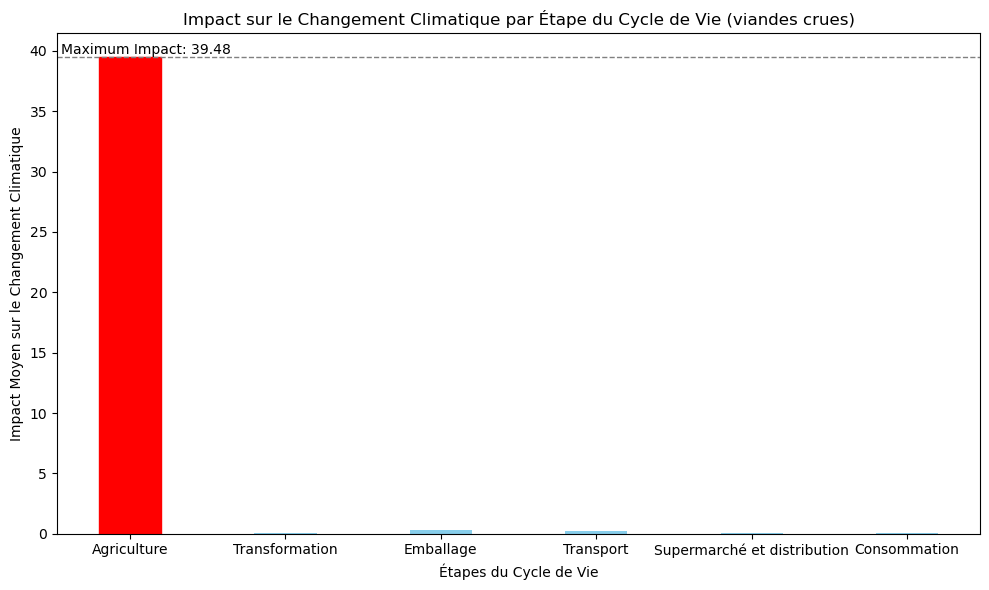

In [44]:
def impact_aliment(
    columns=[], sg_aliment="viandes cuites", df_jointure=df_jointure, title=""
):
    df_sg = df_jointure[df_jointure["Sous-groupe d'aliment"] == sg_aliment]
    cols = ["Code CIQUAL"]
    cols += list(columns)
    df_sg = df_sg[cols]
    df_sg

    f_value, p_value = stats.f_oneway(
        df_sg[columns[0]],
        df_sg[columns[1]],
        df_sg[columns[2]],
        df_sg[columns[3]],
        df_sg[columns[4]],
        df_sg[columns[5]],
    )

    # Afficher les résultats du test ANOVA
    print(f"F-value: {f_value}, P-value: {p_value}")

    # Si le P-value est inférieur à 0.05, cela indique des différences significatives
    if p_value < 0.05:
        print("Des différences significatives existent entre les groupes.")
    else:
        print("Aucune différence significative n'a été trouvée entre les groupes.")

    # Calculer la somme ou la moyenne des impacts pour chaque étape
    impact_argiculture = df_sg[columns[0]].mean()
    impact_transformation = df_sg[columns[1]].mean()
    impact_emballage = df_sg[columns[2]].mean()
    impact_transport = df_sg[columns[3]].mean()
    impact_supermarche = df_sg[columns[4]].mean()
    impact_consommation = df_sg[columns[5]].mean()

    # Créer un dictionnaire pour stocker les résultats
    impacts = {
        "Agriculture": impact_argiculture,
        "Transformation": impact_transformation,
        "Emballage": impact_emballage,
        "Transport": impact_transport,
        "Supermarché et distribution": impact_supermarche,
        "Consommation": impact_consommation,
    }

    # Trouver l'étape avec le plus grand impact
    etape_plus_impact = max(impacts, key=impacts.get)

    print(impacts)

    # Afficher l'étape avec le plus grand impact
    print(
        f"L'étape ayant le plus grand impact sur {title} est : {etape_plus_impact} avec une moyenne de {impacts[etape_plus_impact]}"
    )

    # Trouver l'étape avec le plus grand impact
    etape_plus_impact = max(impacts, key=impacts.get)
    max_value = impacts[etape_plus_impact]

    # Créer le graphique à barres
    plt.figure(figsize=(10, 6))
    bars = plt.bar(impacts.keys(), impacts.values(), color="skyblue", width=0.4)

    # Ajouter des pointillés pour marquer l'étape avec le plus grand impact
    plt.axhline(y=max_value, color="grey", linestyle="--", linewidth=1)
    plt.text(
        0.10,
        max_value,
        f"Maximum Impact: {max_value:.2f}",
        color="black",
        va="bottom",
        ha="center",
    )

    # Mettre en évidence la barre avec le plus grand impact
    bars[list(impacts.keys()).index(etape_plus_impact)].set_color("red")

    # Ajouter des titres et des étiquettes
    plt.title(f"Impact sur {title} par Étape du Cycle de Vie ({sg_aliment})")
    plt.xlabel("Étapes du Cycle de Vie")
    plt.ylabel(f"Impact Moyen sur {title}")
    plt.xticks(rotation=0, ha="center")

    plt.tight_layout()
    plt.show()


impact_aliment(
    columns=df_jointure.columns[39:45],
    sg_aliment="viandes crues",
    df_jointure=df_jointure,
    title="le Changement Climatique",
)

In [45]:
df_jointure.columns[51:57]

Index(['Rayonnements ionisants - Agriculture',
       'Rayonnements ionisants - Transformation',
       'Rayonnements ionisants - Emballage',
       'Rayonnements ionisants - Transport',
       'Rayonnements ionisants - Supermarché et distribution',
       'Rayonnements ionisants - Consommation'],
      dtype='object')

F-value: 108.51744965689447, P-value: 1.8211084259324386e-40
Des différences significatives existent entre les groupes.
{'Agriculture': 1.0752977384210527, 'Transformation': 0.2711147238947368, 'Emballage': 0.00780329855631579, 'Transport': 0.01877087536842105, 'Supermarché et distribution': 0.21738909157894734, 'Consommation': 0.3706953047368421}
L'étape ayant le plus grand impact sur le Rayonnements ionisants est : Agriculture avec une moyenne de 1.0752977384210527


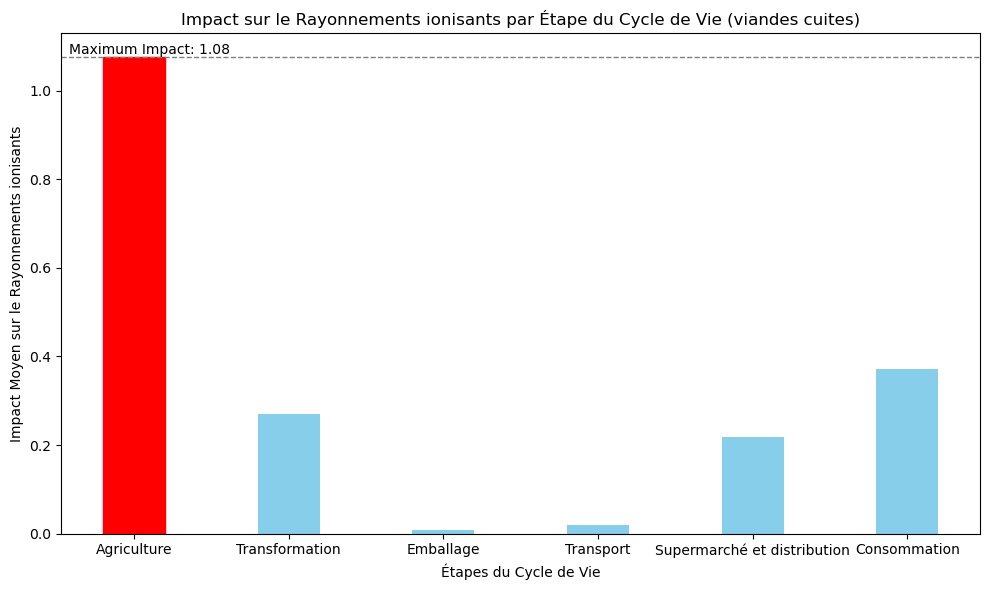

In [46]:
impact_aliment(
    columns=df_jointure.columns[51:57],
    sg_aliment="viandes cuites",
    df_jointure=df_jointure,
    title="le Rayonnements ionisants",
)

In [47]:
df_jointure.columns[81:87]

Index(['Acidification terrestre et eaux douces - Agriculture',
       'Acidification terrestre et eaux douces - Transformation',
       'Acidification terrestre et eaux douces - Emballage',
       'Acidification terrestre et eaux douces - Transport',
       'Acidification terrestre et eaux douces - Supermarché et distribution',
       'Acidification terrestre et eaux douces - Consommation'],
      dtype='object')

F-value: 494.2551975619518, P-value: 1.1130240894849183e-72
Des différences significatives existent entre les groupes.
{'Agriculture': 0.7756445915789473, 'Transformation': 0.0005181697815789474, 'Emballage': 0.0010796290621052631, 'Transport': 0.0011121648284210524, 'Supermarché et distribution': 0.00022176990894736838, 'Consommation': 0.0004682683178947369}
L'étape ayant le plus grand impact sur l'Acidification terrestre et eaux douces est : Agriculture avec une moyenne de 0.7756445915789473


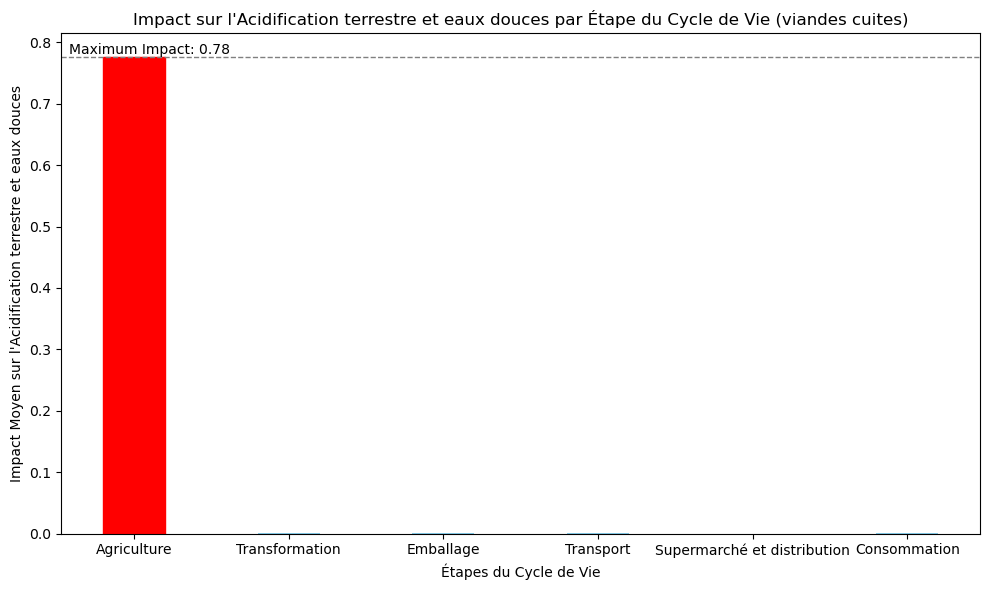

In [48]:
impact_aliment(
    columns=df_jointure.columns[81:87],
    sg_aliment="viandes cuites",
    df_jointure=df_jointure,
    title="l'Acidification terrestre et eaux douces",
)

In [49]:
df_jointure.columns[99:105]

Index(['Eutrophisation terrestre - Agriculture',
       'Eutrophisation terrestre - Transformation',
       'Eutrophisation terrestre - Emballage',
       'Eutrophisation terrestre - Transport',
       'Eutrophisation terrestre - Supermarché et distribution',
       'Eutrophisation terrestre - Consommation'],
      dtype='object')

F-value: 1299671711620.437, P-value: 8.253692869470839e-234
Des différences significatives existent entre les groupes.
{'Agriculture': 3.1963247, 'Transformation': 0.00080091562, 'Emballage': 0.001515560275, 'Transport': 0.002919893525, 'Supermarché et distribution': 0.00033956701, 'Consommation': 0.000299937675}
L'étape ayant le plus grand impact sur l'Eutrophisation terrestre est : Agriculture avec une moyenne de 3.1963247


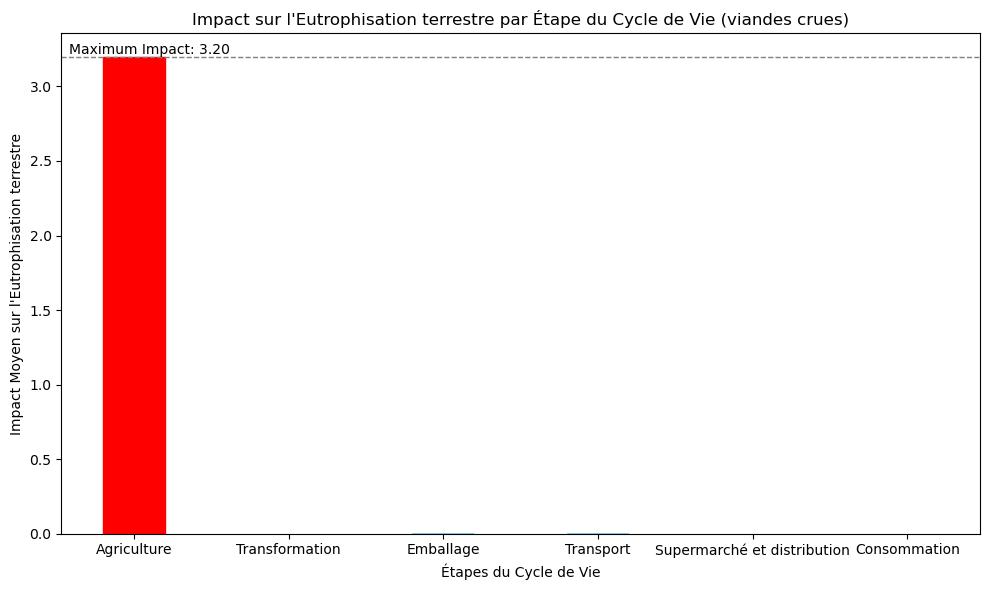

In [50]:
impact_aliment(
    columns=df_jointure.columns[99:105],
    sg_aliment="viandes crues",
    df_jointure=df_jointure,
    title="l'Eutrophisation terrestre",
)

In [51]:
df_jointure.columns[111:117]

Index(['Utilisation du sol - Agriculture',
       'Utilisation du sol - Transformation', 'Utilisation du sol - Emballage',
       'Utilisation du sol - Transport',
       'Utilisation du sol - Supermarché et distribution',
       'Utilisation du sol - Consommation'],
      dtype='object')

F-value: 11240799562001.934, P-value: 1.7394582734215705e-253
Des différences significatives existent entre les groupes.
{'Agriculture': 4376.7473, 'Transformation': 0.1430245, 'Emballage': 0.059019583125, 'Transport': 1.7882479999999998, 'Supermarché et distribution': 0.18381619, 'Consommation': 0.098686365625}
L'étape ayant le plus grand impact sur l'Utilisation du sol est : Agriculture avec une moyenne de 4376.7473


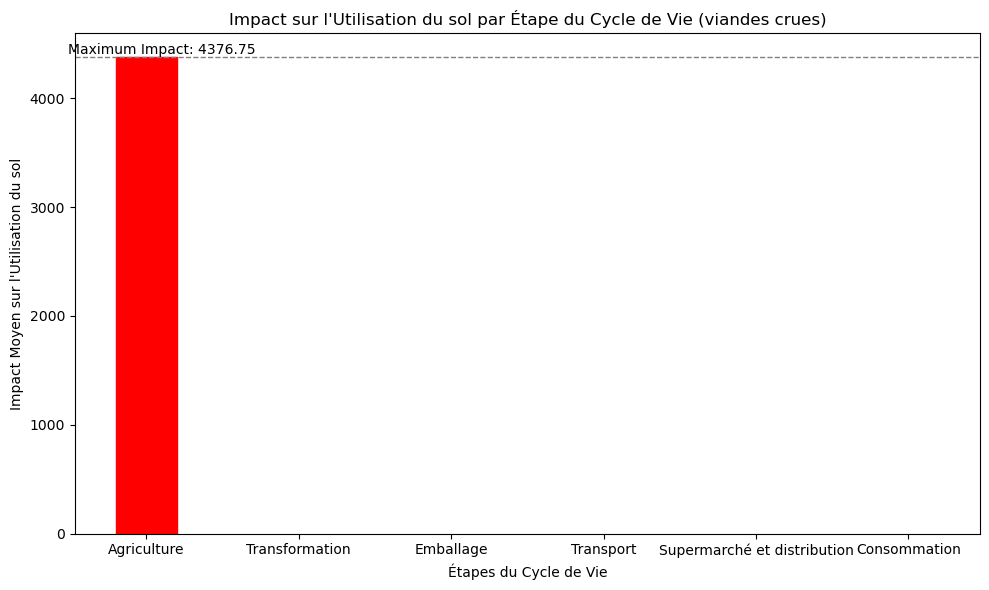

In [52]:
impact_aliment(
    columns=df_jointure.columns[111:117],
    sg_aliment="viandes crues",
    df_jointure=df_jointure,
    title="l'Utilisation du sol",
)

In [53]:
colonnes_selectionnees = [
    "Changement climatique",
    "Effets toxicologiques sur la santé humaine   substances non-cancérogènes",
    "Effets toxicologiques sur la santé humaine   substances cancérogènes",
    "Écotoxicité pour écosystèmes aquatiques d'eau douce",
    "Utilisation du sol",
    "Épuisement des ressources eau",
    "Épuisement des ressources énergétiques",
    "Épuisement des ressources minéraux",
]

# treshold sur la colonne score unique EF
median_value = df_synt["Score unique EF"].median()
labels = np.where(df_synt["Score unique EF"] > median_value, 1, 0)

X = df_synt[colonnes_selectionnees]

print("valeurs 1", len(labels[labels == 1]))
print("valeurs 0", len(labels[labels == 0]))

valeurs 1 1211
valeurs 0 1212


In [54]:
# Refaire l'ACP avec les données normalisées
pca = PCA(n_components=2)
X = df_synt[df_synt.columns[13:29]]
print(X.shape)
X_r = pca.fit_transform(X)

# Afficher les dimensions et les proportions de variance expliquée
summary_table = pd.DataFrame(
    columns=[
        "Dimension",
        "Explained Variance",
        "Explained Variance Ratio",
        "Cumulative Explained Variance Ratio",
    ]
)

# Créer une liste pour stocker les lignes du tableau récapitulatif
rows = []

# Calculer les proportions cumulatives de variance expliquée
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Remplir la liste avec les informations sur chaque dimension
for i in range(len(pca.explained_variance_)):
    rows.append(
        {
            "Dimension": i + 1,
            "Explained Variance": pca.explained_variance_[i],
            "Explained Variance Ratio": pca.explained_variance_ratio_[i],
            "Cumulative Explained Variance Ratio": cumulative_variance_ratio[i],
        }
    )

# Créer le DataFrame récapitulatif en concaténant les lignes
summary_table = pd.concat([pd.DataFrame([row]) for row in rows], ignore_index=True)
summary_table

(2423, 16)


,Dimension,Explained Variance,Explained Variance Ratio,Cumulative Explained Variance Ratio
0,1,437854.216389,0.986072,0.986072
1,2,4101.971905,0.009238,0.995310


In [55]:
print(X_r.shape)

(2423, 2)


In [56]:
# Regressions logistiques
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    roc_curve,
    roc_auc_score,
    precision_score,
    recall_score,
)


def display_results(lr_model, X_test, y_test, y_pred, colonnes_selectionnees):
    # Affichage du rapport de classification
    print(classification_report(y_test, y_pred, target_names=["faibe", "fort"]))

    # Affichage de la matrice de confusion
    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_xlabel("Prédit")
    ax.set_ylabel("Vrai")
    ax.set_title("Matrice de confusion")
    ax.xaxis.set_ticklabels(["faible", "fort"])
    ax.yaxis.set_ticklabels(["faible", "fort"])
    plt.show()

    y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

    # Calcul de la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Calcul de l'aire sous la courbe ROC
    auc = roc_auc_score(y_test, y_pred_proba)

    # Création de la courbe ROC
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.title("Courbe ROC")
    plt.legend(loc="lower right")
    plt.show()

Accuracy: 0.93 (+/- 0.01)
acc :  0.9752066115702479
              precision    recall  f1-score   support

       faibe       0.96      0.97      0.97       239
        fort       0.98      0.96      0.97       246

    accuracy                           0.97       485
   macro avg       0.97      0.97      0.97       485
weighted avg       0.97      0.97      0.97       485



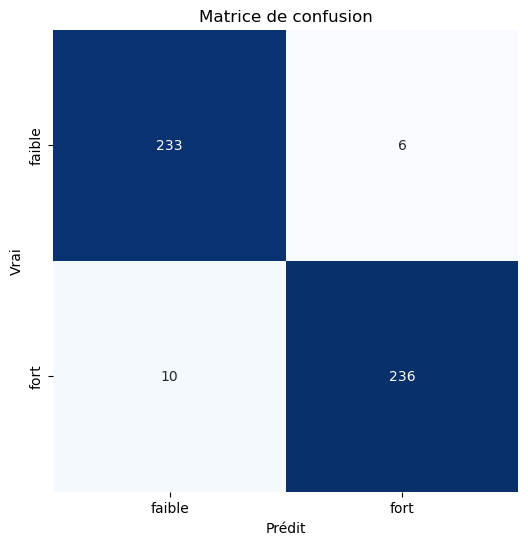

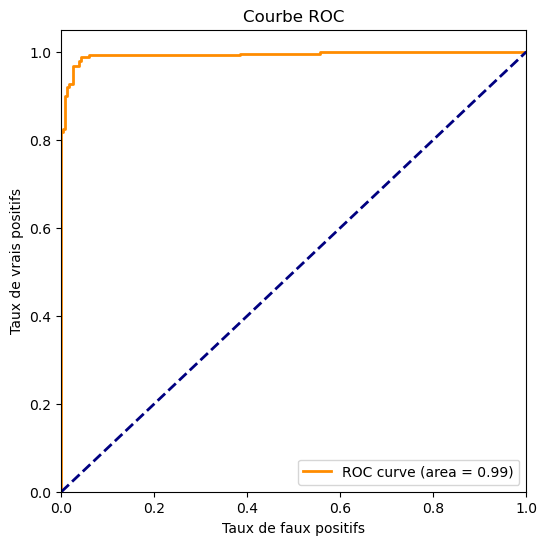

In [57]:
# Division des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X_r, labels, test_size=0.2, random_state=0
)

# Création du modèle de régression logistique
lr_model = LogisticRegression(max_iter=1000)

# Cross validation
scores = cross_val_score(lr_model, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Entraînement du modèle
lr_model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = lr_model.predict(X_test)

print("acc : ", precision_score(y_test, y_pred))

precision_lr = np.where(y_test == y_pred, 1, 0)

# Affichage des résultats
display_results(lr_model, X_test, y_test, y_pred, colonnes_selectionnees)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................C=1, kernel=linear; total time=   7.8s
[CV] END .................................C=1, kernel=linear; total time=   7.7s
[CV] END .................................C=1, kernel=linear; total time=   7.2s
[CV] END .................................C=1, kernel=linear; total time=   8.4s
[CV] END .................................C=1, kernel=linear; total time=   7.7s
{'C': 1, 'kernel': 'linear'}
accuracy: 0.9670103092783505
              precision    recall  f1-score   support

       faibe       0.96      0.97      0.97       239
        fort       0.98      0.96      0.97       246

    accuracy                           0.97       485
   macro avg       0.97      0.97      0.97       485
weighted avg       0.97      0.97      0.97       485



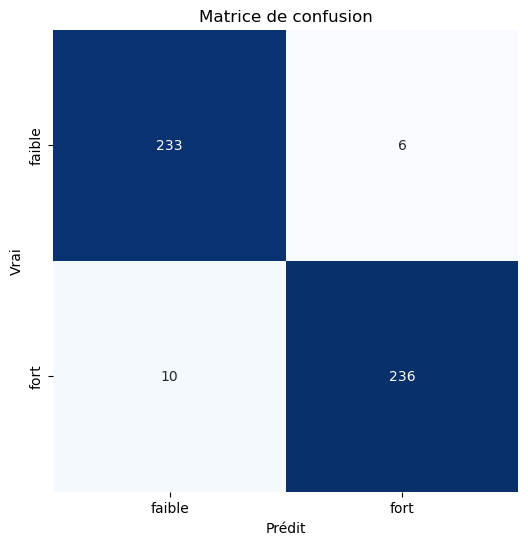

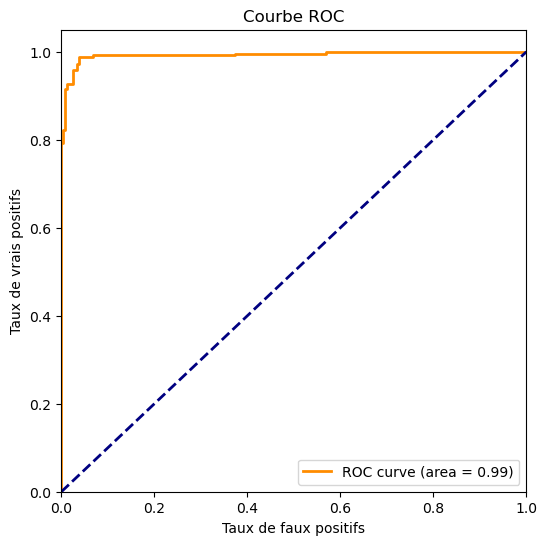

In [58]:
# SVM


# Création du modèle SVM
svm_model = SVC(probability=True)

# Paramètres à tester
param_grid = {
    "C": [1],
    "kernel": ["linear"],
}

# Recherche des meilleurs paramètres
grid = GridSearchCV(svm_model, param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

# Meilleurs paramètres
print(grid.best_params_)

# Prédiction sur l'ensemble de test
y_pred_svm = grid.predict(X_test)
print("accuracy:", grid.score(X_test, y_test))

precision_svm = np.where(y_test == y_pred_svm, 1, 0)

# Affichage des résultats
display_results(grid, X_test, y_test, y_pred_svm, colonnes_selectionnees)

accuracy: 0.9711340206185567
              precision    recall  f1-score   support

       faibe       0.96      0.98      0.97       239
        fort       0.98      0.96      0.97       246

    accuracy                           0.97       485
   macro avg       0.97      0.97      0.97       485
weighted avg       0.97      0.97      0.97       485



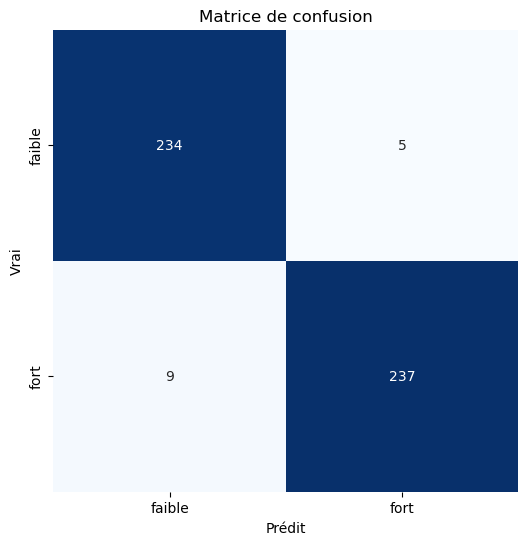

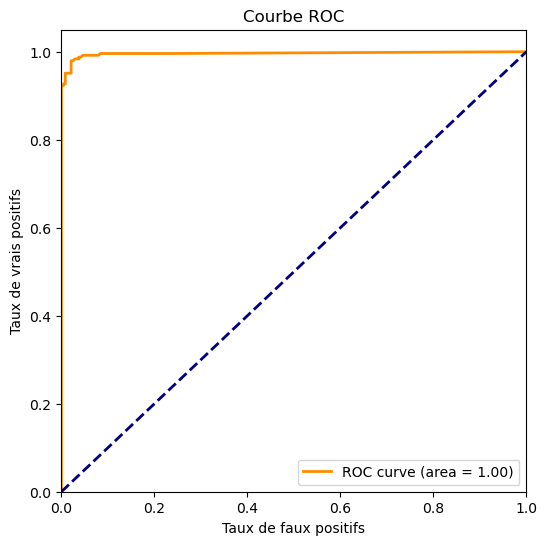

In [59]:
# Random Forest

# Création du modèle Random Forest
rf_model = RandomForestClassifier()

# Entraînement du modèle
rf_model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred_rf = rf_model.predict(X_test)

print("accuracy:", rf_model.score(X_test, y_test))

precision_rf = np.where(y_test == y_pred_rf, 1, 0)

# Affichage des résultats
display_results(rf_model, X_test, y_test, y_pred_rf, colonnes_selectionnees)

accuracy: 0.9649484536082474
              precision    recall  f1-score   support

       faibe       0.96      0.97      0.96       239
        fort       0.97      0.96      0.97       246

    accuracy                           0.96       485
   macro avg       0.96      0.97      0.96       485
weighted avg       0.97      0.96      0.96       485



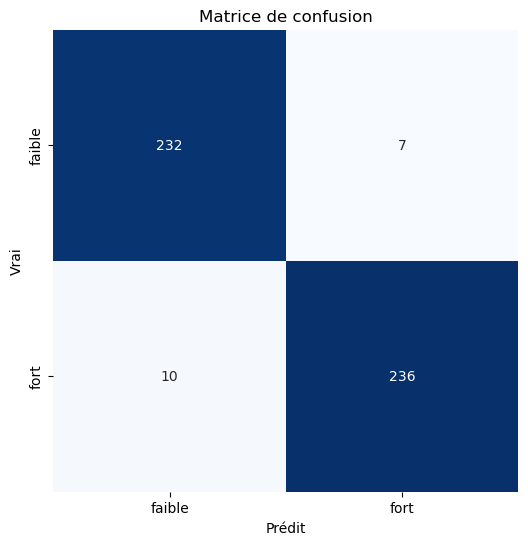

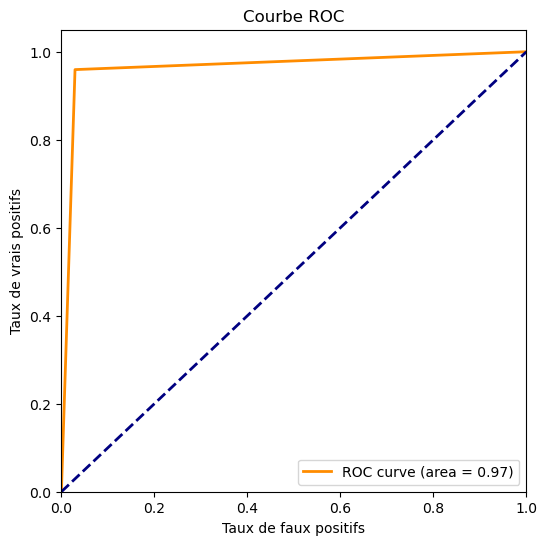

In [60]:
# Decision Tree

# Création du modèle Decision Tree
dt_model = DecisionTreeClassifier()

# Entraînement du modèle
dt_model.fit(X_train, y_train)


# Prédiction sur l'ensemble de test
y_pred_dt = dt_model.predict(X_test)
print("accuracy:", dt_model.score(X_test, y_test))
precision_dt = np.where(y_test == y_pred_dt, 1, 0)

# Affichage des résultats
display_results(dt_model, X_test, y_test, y_pred_dt, colonnes_selectionnees)

accuracy: 0.9711340206185567
              precision    recall  f1-score   support

       faibe       0.97      0.97      0.97       239
        fort       0.97      0.97      0.97       246

    accuracy                           0.97       485
   macro avg       0.97      0.97      0.97       485
weighted avg       0.97      0.97      0.97       485



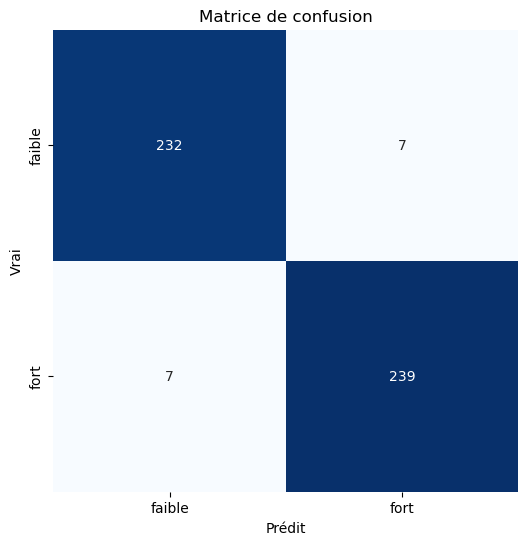

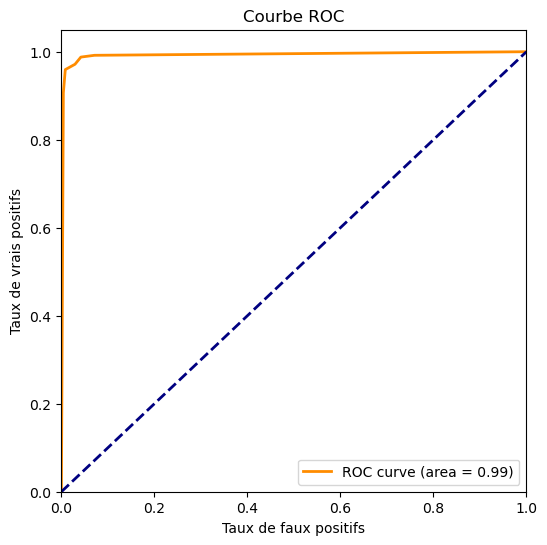

In [61]:
# KNN
# Création du modèle KNN
knn_model = KNeighborsClassifier()

# Entraînement du modèle
knn_model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred_knn = knn_model.predict(X_test)
print("accuracy:", knn_model.score(X_test, y_test))
precision_knn = np.where(y_test == y_pred_knn, 1, 0)

# Affichage des résultats
display_results(knn_model, X_test, y_test, y_pred_knn, colonnes_selectionnees)

In [62]:
def display_roc_curves(models, preds, X_test, y_test):
    plt.figure(figsize=(6, 6))

    # Boucle sur les modèles et les prédictions
    for model, y_pred in zip(models, preds):
        # Calcul des probabilités prédites
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calcul de la courbe ROC
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

        # Calcul de l'aire sous la courbe ROC
        auc = roc_auc_score(y_test, y_pred_proba)

        # Création de la courbe ROC

        if isinstance(model, GridSearchCV):
            label = "ROC curve (area = %0.2f) for SVM" % auc
        else:
            label = "ROC curve (area = %0.2f) for %s" % (auc, type(model).__name__)

        plt.plot(fpr, tpr, lw=2, label=label)

    # Ajout de la ligne diagonale
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.title("Courbe ROC")
    plt.legend(loc="lower right")
    plt.show()

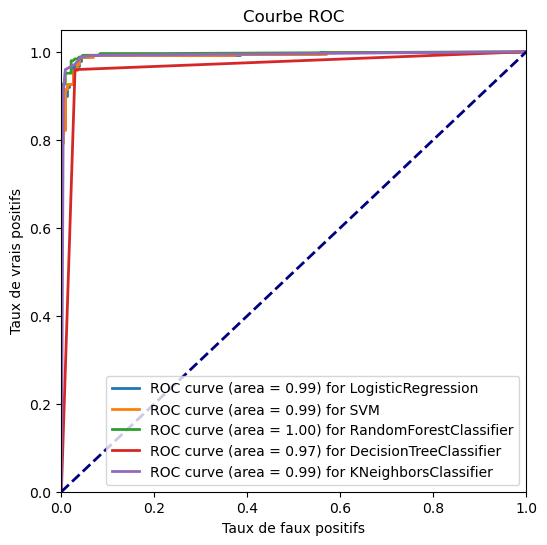

In [63]:
display_roc_curves(
    [lr_model, grid, rf_model, dt_model, knn_model],
    [y_pred, y_pred_svm, y_pred_rf, y_pred_dt, y_pred_knn],
    X_test,
    y_test,
)

In [64]:
len(precision_svm)

485

In [65]:
# Ttest
from scipy.stats import ttest_rel
import pandas as pd


model_names = ["Logistic Regression", "SVM", "Random Forest", "Decision Tree", "KNN"]


# Calcul de la précision pour chaque modèle
precisions = [precision_lr, precision_svm, precision_rf, precision_dt, precision_knn]


# Calcul du test t de Student apparié pour chaque paire de modèles


t_stats = []
p_vals = []
model1_list = []
model2_list = []
hypothesis_results = []


alpha = 0.05


for i in range(len(precisions)):
    for j in range(i + 1, len(precisions)):

        t_stat, p_val = ttest_rel(precisions[i], precisions[j])
        model1_list.append(model_names[i])

        model2_list.append(model_names[j])
        t_stats.append(t_stat)
        p_vals.append(p_val)

        hypothesis_results.append("Reject H0" if p_val < alpha else "Fail to reject H0")


# Création d'un DataFrame pour l'affichage


df = pd.DataFrame(
    {
        "Model-1": model1_list,
        "Model-2": model2_list,
        "t-statistic": t_stats,
        "p-value": p_vals,
        "Hypothesis Result": hypothesis_results,
    }
)


display(df)

,Model-1,Model-2,t-statistic,p-value,Hypothesis Result
0,Logistic Regression,SVM,NaN,NaN,Fail to reject H0
1,Logistic Regression,Random Forest,-0.471026,0.637834,Fail to reject H0
2,Logistic Regression,Decision Tree,0.229192,0.818817,Fail to reject H0
3,Logistic Regression,KNN,-0.499613,0.617575,Fail to reject H0
4,SVM,Random Forest,-0.471026,0.637834,Fail to reject H0
5,SVM,Decision Tree,0.229192,0.818817,Fail to reject H0
6,SVM,KNN,-0.499613,0.617575,Fail to reject H0
7,Random Forest,Decision Tree,1.342751,0.179982,Fail to reject H0
8,Random Forest,KNN,0.000000,1.000000,Fail to reject H0
9,Decision Tree,KNN,-0.904364,0.366252,Fail to reject H0


In [66]:
# Test ANOVA
f_value, p_value = stats.f_oneway(
    precision_lr, precision_svm, precision_rf, precision_dt, precision_knn
)
print(f"F-value: {f_value}, P-value: {p_value}")

# Si le P-value est inférieur à 0.05, cela indique des différences significatives
if p_value < 0.05:
    print("Des différences significatives existent entre les groupes.")
else:
    print("Aucune différence significative n'a été trouvée entre les groupes.")

F-value: 0.12049125912812567, P-value: 0.9752184592248448
Aucune différence significative n'a été trouvée entre les groupes.


In [67]:
models = {
    "Régression Logistique": lr_model,
    "SVM": grid,
    "Random Forest": rf_model,
    "Arbre de Décision": dt_model,
    "KNN": knn_model,
}

# Dashboard

In [69]:
import dash
from dash import dcc, html
import plotly.express as px
import plotly.graph_objs as go
from dash.dependencies import Input, Output
from pyngrok import ngrok

app = dash.Dash(__name__)

app.layout = html.Div(
    children=[
        html.H1(
            children="Impact des Aliments Sur L'environnement",
            style={
                "textAlign": "center",
                "color": "#2c3e50",
                "fontFamily": "Arial, sans-serif",
            },
        ),
        html.Div(
            children="""Dashboard interactif basé sur les données Agribalyse.""",
            style={
                "textAlign": "center",
                "color": "#34495e",
                "fontFamily": "Arial, sans-serif",
            },
        ),
        dcc.Tabs(
            id="tabs",
            children=[
                dcc.Tab(
                    label="Vue d’ensemble",
                    style={
                        "backgroundColor": "#ecf0f1",
                        "borderBottom": "1px solid #bdc3c7",
                        "borderRadius": "8px 8px 8px 8px",
                        # hover effect
                    },
                    selected_style={"backgroundColor": "#bdc3c7", "color": "#2c3e50"},
                    children=[
                        html.Div(
                            style={
                                "padding": "20px",
                                "backgroundColor": "#f4f0ec",
                                "borderRadius": "8px",
                                # "boxShadow": "0 4px 8px rgba(0, 0, 0, 0.1)",
                                "boxShadow": "rgba(50, 50, 93, 0.25) 0px 30px 60px -12px inset, rgba(0, 0, 0, 0.3) 0px 18px 36px -18px inset",
                            },
                            children=[
                                dcc.Graph(
                                    id="histogram",
                                    figure=px.histogram(
                                        df_synt,
                                        x="Score unique EF",  # Garder votre colonne
                                        title="Distribution du Score unique EF",
                                    ),
                                )
                            ],
                        )
                    ],
                ),
                dcc.Tab(
                    label="Clusters et Scores",
                    style={
                        "backgroundColor": "#ecf0f1",
                        "borderBottom": "1px solid #bdc3c7",
                        "borderRadius": "8px 8px 8px 8px",
                    },
                    selected_style={"backgroundColor": "#bdc3c7", "color": "#2c3e50"},
                    children=[
                        html.Div(
                            style={
                                "padding": "20px",
                                "backgroundColor": "#f4f0ec",
                                "borderRadius": "8px",
                                "boxShadow": "0 4px 8px rgba(0, 0, 0, 0.1)",
                            },
                            children=[
                                dcc.Graph(id="cluster-bar-chart"),
                                dcc.Graph(id="cluster-composition"),
                                dcc.Graph(id="cluster-tsne-plot"),
                            ],
                        )
                    ],
                ),
                dcc.Tab(
                    label="Impact par Étape",
                    style={
                        "backgroundColor": "#ecf0f1",
                        "borderBottom": "1px solid #bdc3c7",
                        "borderRadius": "8px 8px 8px 8px",
                    },
                    selected_style={"backgroundColor": "#bdc3c7", "color": "#2c3e50"},
                    children=[
                        html.Div(
                            style={
                                "padding": "20px",
                                "backgroundColor": "#f4f0ec",
                                "borderRadius": "8px",
                                "boxShadow": "0 4px 8px rgba(0, 0, 0, 0.1)",
                            },
                            children=[
                                dcc.Dropdown(
                                    id="dropdown-subgroup",
                                    options=[
                                        {"label": subgroup, "value": subgroup}
                                        for subgroup in df_eta[
                                            "Sous-groupe d'aliment"
                                        ].unique()
                                    ],
                                    value=None,
                                    placeholder="--- Sélectionnez un sous-groupe d'aliment ---",
                                    style={
                                        "width": "48%",
                                        "display": "inline-block",
                                        "borderRadius": "20px",
                                    },
                                ),
                                dcc.Dropdown(
                                    id="dropdown-indicator",
                                    options=[
                                        {
                                            "label": "Changement climatique",
                                            "value": "Changement climatique",
                                        },
                                        {
                                            "label": "Appauvrissement de la couche d'ozone",
                                            "value": "Appauvrissement de la couche d'ozone",
                                        },
                                        {
                                            "label": "Rayonnements ionisants",
                                            "value": "Rayonnements ionisants",
                                        },
                                        {
                                            "label": "Formation photochimique d'ozone",
                                            "value": "Formation photochimique d'ozone",
                                        },
                                        {
                                            "label": "Particules fines",
                                            "value": "Particules fines",
                                        },
                                        {
                                            "label": "Effets toxicologiques sur la santé humaine   substances non-cancérogènes",
                                            "value": "Effets toxicologiques sur la santé humaine   substances non-cancérogènes",
                                        },
                                        {
                                            "label": "Effets toxicologiques sur la santé humaine   substances cancérogènes",
                                            "value": "Effets toxicologiques sur la santé humaine   substances cancérogènes",
                                        },
                                        {
                                            "label": "Écotoxicité pour écosystèmes aquatiques d'eau douce",
                                            "value": "Écotoxicité pour écosystèmes aquatiques d'eau douce",
                                        },
                                        {
                                            "label": "Utilisation du sol",
                                            "value": "Utilisation du sol",
                                        },
                                        {
                                            "label": "Épuisement des ressources eau",
                                            "value": "Épuisement des ressources eau",
                                        },
                                        {
                                            "label": "Épuisement des ressources énergétiques",
                                            "value": "Épuisement des ressources énergétiques",
                                        },
                                        {
                                            "label": "Épuisement des ressources minéraux",
                                            "value": "Épuisement des ressources minéraux",
                                        },
                                    ],
                                    value=None,
                                    placeholder="--- Sélectionnez un indicateur ---",
                                    style={
                                        "width": "48%",
                                        "float": "right",
                                        "display": "inline-block",
                                        # border radius for dropdown
                                        "borderRadius": "20px",
                                    },
                                ),
                                dcc.Graph(id="step-impact-bar-chart"),
                            ],
                        )
                    ],
                ),
                dcc.Tab(
                    label="Modèles",
                    style={
                        "backgroundColor": "#ecf0f1",
                        "borderBottom": "1px solid #bdc3c7",
                        "borderRadius": "8px 8px 8px 8px",
                    },
                    selected_style={"backgroundColor": "#bdc3c7", "color": "#2c3e50"},
                    children=[
                        html.Div(
                            style={
                                "display": "flex",
                                "padding": "20px",
                                "backgroundColor": "#f5f5f5",
                                "borderRadius": "8px",
                                "boxShadow": "0 4px 8px rgba(0, 0, 0, 0.1)",
                            },
                            children=[
                                html.Div(
                                    style={
                                        "flex": "1",
                                        "marginRight": "20px",
                                        "padding": "10px",
                                        "backgroundColor": "#f4f0ec",
                                        "borderRadius": "8px",
                                        "boxShadow": "0 4px 8px rgba(0, 0, 0, 0.1)",
                                    },
                                    children=[
                                        html.Div(
                                            style={
                                                "padding": "20px",
                                                "backgroundColor": "#ffffff",
                                                "borderRadius": "8px",
                                                "boxShadow": "rgba(0, 0, 0, 0.25) 0px 54px 55px, rgba(0, 0, 0, 0.12) 0px -12px 30px, rgba(0, 0, 0, 0.12) 0px 4px 6px, rgba(0, 0, 0, 0.17) 0px 12px 13px, rgba(0, 0, 0, 0.09) 0px -3px 5px",
                                            },
                                            children=[
                                                html.Label(
                                                    "Choisissez un modèle :",
                                                    style={
                                                        "fontFamily": "Arial, sans-serif"
                                                    },
                                                ),
                                                dcc.RadioItems(
                                                    id="model-radio",
                                                    options=[
                                                        {"label": model, "value": model}
                                                        for model in models.keys()
                                                    ],
                                                    value="Régression Logistique",  # valeur par défaut
                                                    labelStyle={"display": "block"},
                                                ),
                                            ],
                                        ),
                                        html.Div(
                                            style={
                                                "marginTop": "10px",
                                                "padding": "20px",
                                                "backgroundColor": "#ffffff",
                                                "borderRadius": "8px",
                                                "boxShadow": "rgba(0, 0, 0, 0.25) 0px 54px 55px, rgba(0, 0, 0, 0.12) 0px -12px 30px, rgba(0, 0, 0, 0.12) 0px 4px 6px, rgba(0, 0, 0, 0.17) 0px 12px 13px, rgba(0, 0, 0, 0.09) 0px -3px 5px",
                                            },
                                            children=[
                                                html.Label(
                                                    "Métriques à afficher :",
                                                    style={
                                                        "fontFamily": "Arial, sans-serif"
                                                    },
                                                ),
                                                dcc.Checklist(
                                                    id="metric-checklist",
                                                    options=[
                                                        {
                                                            "label": "Matrice de Confusion",
                                                            "value": "confusion_matrix",
                                                        },
                                                        {
                                                            "label": "Rapport de Classification",
                                                            "value": "classification_report",
                                                        },
                                                        {
                                                            "label": "Courbe ROC",
                                                            "value": "roc_curve",
                                                        },
                                                    ],
                                                    value=[
                                                        "roc_curve"
                                                    ],  # valeur par défaut
                                                    labelStyle={"display": "block"},
                                                ),
                                            ],
                                        ),
                                    ],
                                ),
                                html.Div(
                                    id="graph-output",
                                    style={
                                        "flex": "3",
                                        "padding": "20px",
                                        "backgroundColor": "#ffffff",
                                        "borderRadius": "8px",
                                        "boxShadow": "rgba(0, 0, 0, 0.25) 0px 54px 55px, rgba(0, 0, 0, 0.12) 0px -12px 30px, rgba(0, 0, 0, 0.12) 0px 4px 6px, rgba(0, 0, 0, 0.17) 0px 12px 13px, rgba(0, 0, 0, 0.09) 0px -3px 5px",
                                    },
                                ),
                            ],
                        ),
                    ],
                ),
            ],
            style={"fontFamily": "Arial, sans-serif"},
        ),
    ],
    style={
        "margin": "auto",
        "marginTop": "70px",
        "maxWidth": "1300px",
        "padding": "20px",
        "backgroundColor": "#faebd7",
        "borderRadius": "8px",
        # "boxShadow": "0 4px 8px rgba(0, 0, 0, 0.1)",
        "boxShadow": "rgba(0, 0, 0, 0.25) 0px 54px 55px, rgba(0, 0, 0, 0.12) 0px -12px 30px, rgba(0, 0, 0, 0.12) 0px 4px 6px, rgba(0, 0, 0, 0.17) 0px 12px 13px, rgba(0, 0, 0, 0.09) 0px -3px 5px",
    },
)


@app.callback(Output("cluster-bar-chart", "figure"), [Input("tabs", "value")])
def update_cluster_bar_chart(_):
    cluster_labels = list(clusters.keys())
    aliments_par_cluster = [len(clusters[cluster]) for cluster in cluster_labels]
    scores_moyens_ef = [moyennes_clusters[cluster] for cluster in cluster_labels]

    fig = go.Figure()

    # Bar chart for the number of foods per cluster
    fig.add_trace(
        go.Bar(
            x=cluster_labels,
            y=aliments_par_cluster,
            name="Nombre d'Aliments",
            marker_color="skyblue",
            yaxis="y1",
        )
    )

    # Line chart for the average EF scores
    fig.add_trace(
        go.Scatter(
            x=cluster_labels,
            y=scores_moyens_ef,
            mode="lines+markers",
            name="Score EF Moyen",
            marker_color="red",
            yaxis="y2",
        )
    )

    fig.update_layout(
        title="Nombre d'Aliments et Score EF Moyen par Cluster (cliquer sur chaque cluster pour voir les détails)",
        xaxis_title="Numéro du Cluster",
        yaxis=dict(
            title="Nombre d'Aliments",
            titlefont=dict(color="skyblue"),
            tickfont=dict(color="skyblue"),
        ),
        yaxis2=dict(
            title="Score EF Moyen",
            titlefont=dict(color="red"),
            tickfont=dict(color="red"),
            overlaying="y",
            side="right",
        ),
        legend=dict(x=0.1, y=0.9),
    )

    return fig


@app.callback(Output("cluster-tsne-plot", "figure"), [Input("tabs", "value")])
def update_tsne_plot(_):
    df_tsne = pd.DataFrame(tsne_data, columns=["x", "y"])
    df_tsne["cluster"] = pred
    fig = px.scatter(
        df_tsne, x="x", y="y", color="cluster", title="TSNE Plot des Clusters"
    )
    return fig


@app.callback(
    Output("step-impact-bar-chart", "figure"),
    [Input("dropdown-subgroup", "value"), Input("dropdown-indicator", "value")],
)
def update_step_impact_chart(selected_subgroup, selected_indicator):
    if not selected_subgroup or not selected_indicator:
        return go.Figure()  # Retourne une figure vide si l'une des valeurs est None
    df_sg = df_eta[df_eta["Sous-groupe d'aliment"] == selected_subgroup]

    col1 = selected_indicator + " - Agriculture"
    col2 = selected_indicator + " - Transformation"
    col3 = selected_indicator + " - Emballage"
    col4 = selected_indicator + " - Transport"
    col5 = selected_indicator + " - Supermarché et distribution"
    col6 = selected_indicator + " - Consommation"

    impacts = {
        "Agriculture": df_sg[col1].mean(),
        "Transformation": df_sg[col2].mean(),
        "Emballage": df_sg[col3].mean(),
        "Transport": df_sg[col4].mean(),
        "Supermarché et distribution": df_sg[col5].mean(),
        "Consommation": df_sg[col6].mean(),
    }

    etape_plus_impact = max(impacts, key=impacts.get)
    max_value = impacts[etape_plus_impact]

    fig = go.Figure()
    fig.add_trace(
        go.Bar(
            x=list(impacts.keys()),
            y=list(impacts.values()),
            marker_color=[
                "skyblue" if step != etape_plus_impact else "red"
                for step in impacts.keys()
            ],
            name="Plus Impactant",
        )
    )

    fig.add_trace(
        go.Scatter(
            x=list(impacts.keys()),
            y=[max_value] * len(impacts),
            mode="lines",
            name="Maximum Impact",
            line=dict(color="grey", dash="dash"),
        )
    )

    fig.update_layout(
        title=f"Impact sur {selected_indicator} par Étape du Cycle de Vie ({selected_subgroup})",
        xaxis_title="Étapes du Cycle de Vie",
        yaxis_title=f"Impact Moyen sur {selected_indicator}",
    )

    return fig


@app.callback(
    Output("cluster-composition", "figure"),
    [
        Input(
            "cluster-bar-chart", "clickData"
        ),  # obtenir les données du cluster cliqué
    ],
)
def update_cluster_bar_chart(clickData):
    if clickData:
        cluster_clicked = clickData["points"][0]["pointIndex"]
        aliments_scores_cluster = clusters[cluster_clicked]

        # Calculer les scores moyens des aliments pour le cluster sélectionné
        cumul_scores_ef = defaultdict(lambda: [0, 0])
        for aliment, score_ef in aliments_scores_cluster:
            cumul_scores_ef[aliment][0] += score_ef
            cumul_scores_ef[aliment][1] += 1

        moyennes_scores_ef = {
            aliment: total_score / count
            for aliment, (total_score, count) in cumul_scores_ef.items()
        }

        aliments_moyennes = sorted(
            moyennes_scores_ef.items(), key=lambda item: item[1], reverse=True
        )
        noms_aliments_moyennes = [aliment for aliment, _ in aliments_moyennes]
        moyennes_ef = [moyenne for _, moyenne in aliments_moyennes]

        fig = go.Figure()
        fig.add_trace(
            go.Bar(
                y=noms_aliments_moyennes,
                x=moyennes_ef,
                orientation="h",
                marker_color="green",
            )
        )

        fig.update_layout(
            title=f"Moyenne de l'Impact Environnemental des Aliments du cluster {cluster_clicked}",
            xaxis_title="Moyenne du Score EF",
            yaxis_title="Aliments",
            yaxis=dict(autorange="reversed"),
        )

        return fig

    # Si aucun cluster n'est sélectionné, renvoyer un graphique vide
    return go.Figure()


@app.callback(
    Output("graph-output", "children"),
    [
        Input("model-radio", "value"),
        Input("metric-checklist", "value"),
    ],
)
def update_graph(selected_model, selected_metrics):
    model = models[selected_model]
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    figures = []

    if "confusion_matrix" in selected_metrics:
        conf_mat = confusion_matrix(y_test, y_pred)
        trace = go.Heatmap(
            z=conf_mat,
            x=["faible", "fort"],
            y=["faible", "fort"],
            colorscale="Blues",
            showscale=False,
        )
        fig = go.Figure(data=trace)
        annotations = []
        for i, row in enumerate(conf_mat):
            for j, value in enumerate(row):
                annotations.append(
                    dict(
                        x=j,
                        y=i,
                        text=str(value),
                        showarrow=False,
                        font=dict(size=14, color="black"),
                    )
                )
        fig.update_layout(
            title="Matrice de Confusion",
            xaxis=dict(title="Prédit", side="bottom"),
            yaxis=dict(title="Vrai", autorange="reversed"),
            annotations=annotations,
        )
        figures.append(dcc.Graph(figure=fig))

    if "classification_report" in selected_metrics:
        # Afficher juste la précision, le recall et le f1-score
        f1_scores = precision_score(y_test, y_pred, average=None)
        precision = precision_score(y_test, y_pred, average=None)
        recall = recall_score(y_test, y_pred, average=None)
        trace = go.Table(
            header=dict(values=["Classe", "Précision", "Rappel", "F1-Score"]),
            cells=dict(values=[["faible", "fort"], precision, recall, f1_scores]),
        )
        fig = go.Figure(trace)
        fig.update_layout(title="Rapport de Classification")
        figures.append(dcc.Graph(figure=fig))

    if "roc_curve" in selected_metrics:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        trace = go.Scatter(
            x=fpr, y=tpr, mode="lines", name=f"Courbe ROC (AUC = {auc:.2f})"
        )
        fig = go.Figure(trace)
        fig.add_trace(
            go.Scatter(
                x=[0, 1],
                y=[0, 1],
                mode="lines",
                line=dict(dash="dash"),
                name="Guess aléatoire",
            )
        )
        fig.update_layout(
            title="Courbe ROC",
            xaxis_title="Taux de faux positifs",
            yaxis_title="Taux de vrais positifs",
        )
        figures.append(dcc.Graph(figure=fig))

    return [dcc.Graph(figure=fig.figure) for fig in figures]


# Ouvrir un tunnel ngrok sur le port 8050
public_url = ngrok.connect(8050)
print("Public URL:", public_url)

# Démarrer le serveur Dash
app.run_server(debug=True, port=8050)

Public URL: NgrokTunnel: "https://f567-93-26-147-219.ngrok-free.app" -> "http://localhost:8050"


t=2024-05-24T11:28:03+0200 lvl=eror msg="heartbeat timeout, terminating session" obj=tunnels.session obj=csess id=27a29a513ee9 clientid=216484127c3a0f564558fcfcb66e7ff3
t=2024-05-24T11:28:03+0200 lvl=eror msg="session closed, starting reconnect loop" obj=tunnels.session obj=csess id=c156dce8e5b1 err="session closed"
t=2024-05-24T12:15:03+0200 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="failed to dial ngrok server with address \"connect.us.ngrok-agent.com:443\": dial tcp: lookup connect.us.ngrok-agent.com: i/o timeout"
t=2024-05-24T12:15:04+0200 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="failed to dial ngrok server with address \"connect.us.ngrok-agent.com:443\": dial tcp: lookup connect.us.ngrok-agent.com: no such host"
t=2024-05-24T12:15:05+0200 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="failed to dial ngrok server with address \"connect.us.ngrok-agent.com:443\": dial tcp: lookup connect.us.ngrok-agent.com: no s